In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.offline as py
import seaborn as sb
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.cluster import KMeans

In [2]:
def load_data():
    return pd.read_csv('./insurance.csv')

# Exporatory analysis

In [3]:
df = load_data()
df

age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe()

age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

In [6]:
print('Column Name\tNaN\tType     \tColumn Data Class')
print('------------------------------------------------------------------')
for c in df.columns:
    print(f'{c}     \t{df[c].isna().sum()}  \t{df[c].dtype}     \t{df[c].apply(type).unique()}')

Column Name	NaN	Type     	Column Data Class
------------------------------------------------------------------
age     	0  	int64     	[<class 'int'>]
sex     	0  	object     	[<class 'str'>]
bmi     	0  	float64     	[<class 'float'>]
children     	0  	int64     	[<class 'int'>]
smoker     	0  	object     	[<class 'str'>]
region     	0  	object     	[<class 'str'>]
charges     	0  	float64     	[<class 'float'>]


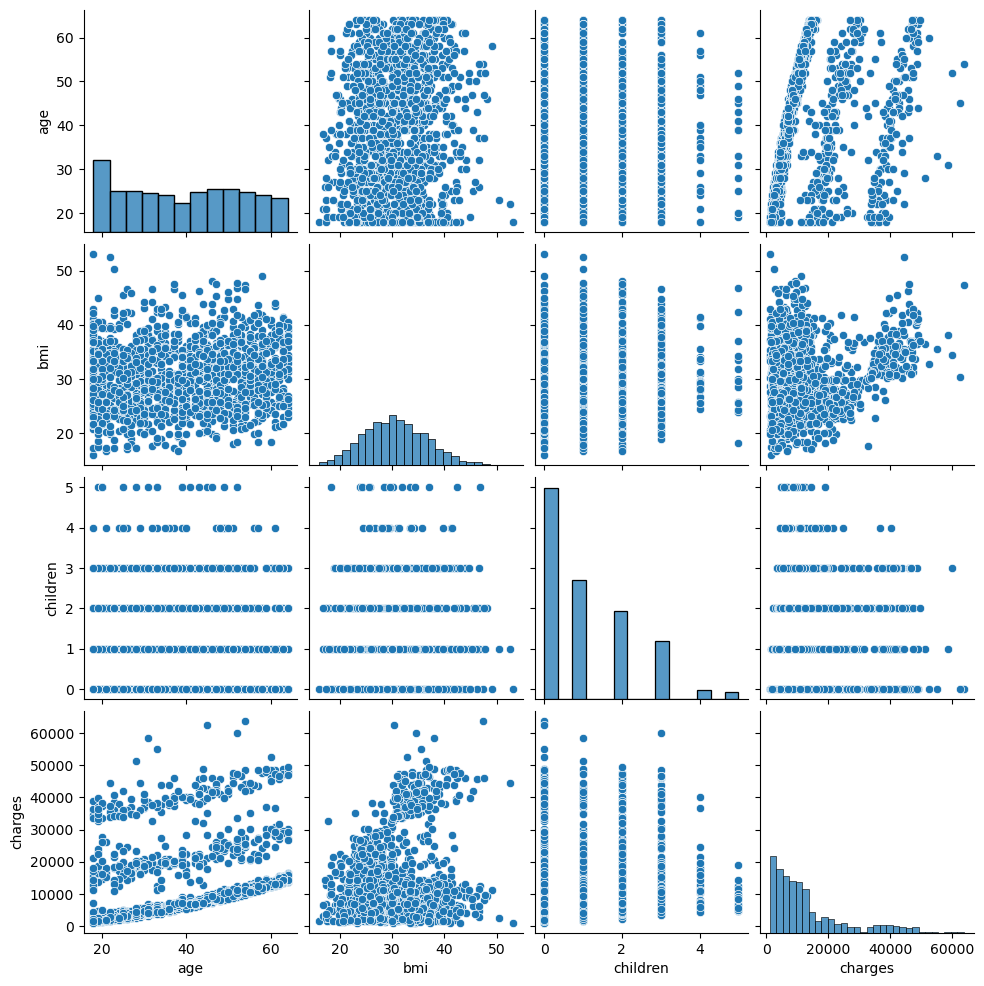

In [3]:
sb.pairplot(df);

## Distribution by age and sex

Without considering specific cases (18-19 years old people), the dataset is almost perfectly balanced regarding age and sex distribution.

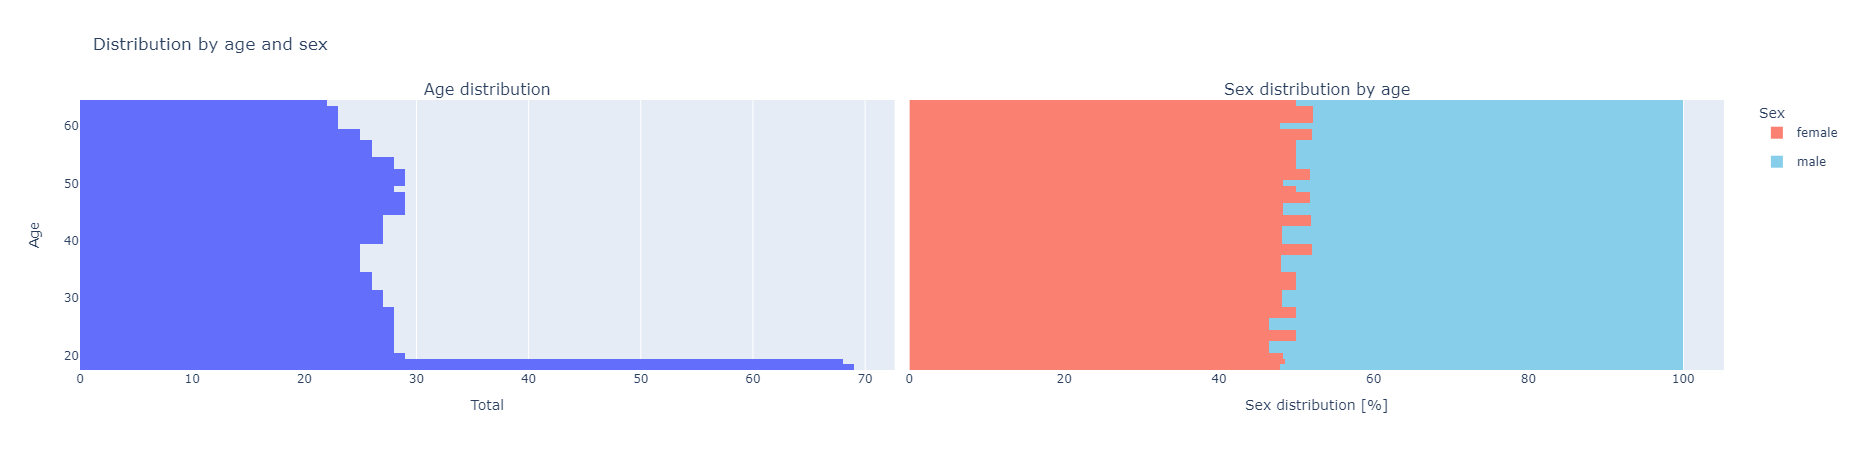

In [243]:
age = df.groupby(['age','sex']).size().reset_index(name='tot')
age['age_percent'] = age.groupby('age').apply(lambda x: 100 * x['tot'] / x['tot'].sum()).values

figures = [   
    px.histogram(df, y='age', orientation='h', nbins=len(df.age.unique())),
    px.histogram(age, y='age', color='sex', x='age_percent', orientation='h', barnorm='percent', color_discrete_map={'female':'salmon', 'male':'skyblue'})
]

fig = sp.make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("Age distribution", "Sex distribution by age"), horizontal_spacing=0.009)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i+1)
        
fig.update_yaxes(title_text="Age",  row=1, col=1)
fig.update_xaxes(title_text="Total",  row=1, col=1)
fig.update_xaxes(title_text="Sex distribution [%]",  row=1, col=2)

fig.layout['legend']['title']['text'] = 'Sex'
fig.update_layout(
    title_text="Distribution by age and sex",
    barmode="stack",
    height=450
)

fig.show()

## BMI distribution

BMI CLASSES

< 16.5			SEVERE THINNESS \
16-18,49		UNDERWEIGHT \
18.5-24,99		NORMAL RANGE \
25-29,99		OVERWEIGHT \
30-34,99		OBESITY CLASS I \
35-39,99		OBESITY CLASS II \
\> 40			OBESITY CLASS III

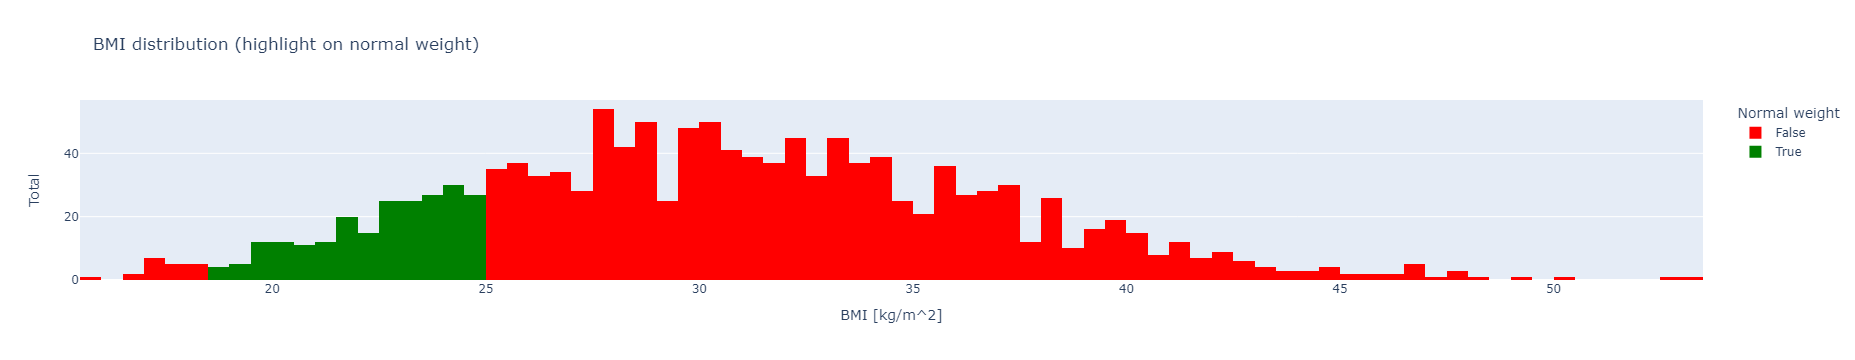

In [208]:
fig = px.histogram(df, x='bmi', color=((df.bmi >= 18.5) & (df.bmi <= 24.99)), nbins=round((df.bmi.max() - df.bmi.min()) * 2 + 1), title='BMI distribution (highlight on normal weight)', color_discrete_map={True:'green', False:'red'})
fig.layout['xaxis']['title'] = 'BMI [kg/m^2]'
fig.layout['yaxis']['title'] = 'Total'
fig.layout['legend']['title']['text'] = 'Normal weight'
fig.show()

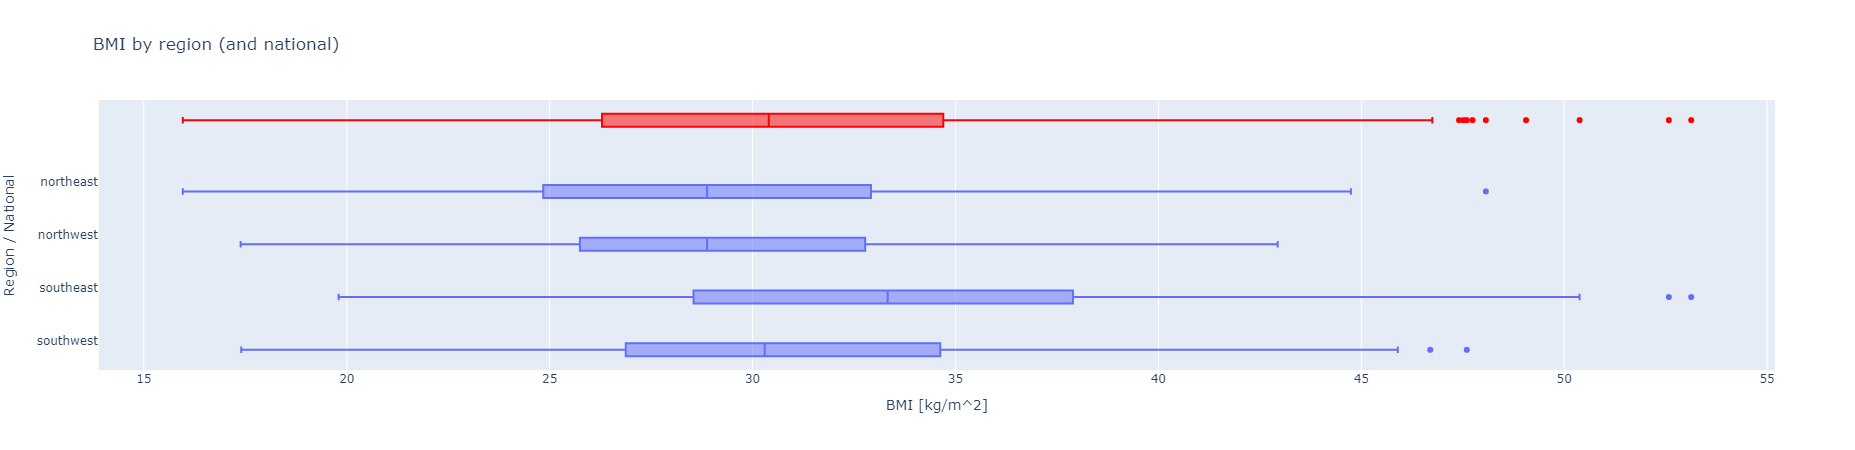

In [207]:
fig = px.box(df, x='bmi', y='region', orientation='h', title='BMI by region (and national)', height=450)
fig.add_trace(px.box(df, x='bmi', color_discrete_sequence=['red'], title='National').data[0])

fig.layout['xaxis']['title'] = 'BMI [kg/m^2]'
fig.layout['yaxis']['title'] = 'Region / National'
fig.show()

It appears that the average medical charges increase for obese people.

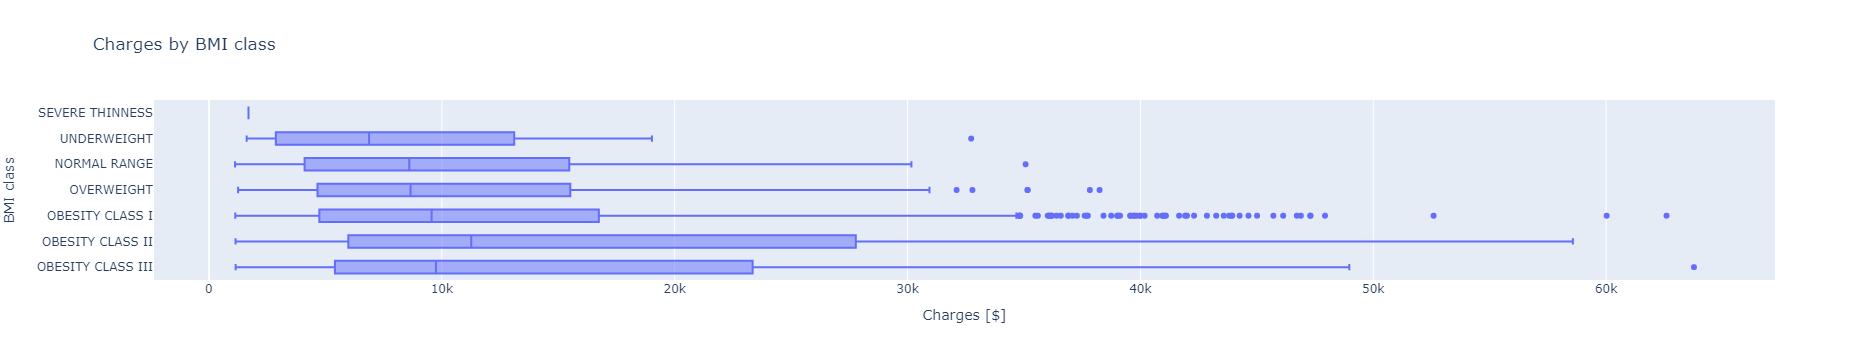

In [406]:
# < 16			SEVERE THINNESS \
# 16-18,49		UNDERWEIGHT \
# 18.5-24,99		NORMAL RANGE \
# 25-29,99		OVERWEIGHT \
# 30-34,99		OBESITY CLASS I \
# 35-39,99		OBESITY CLASS II \
# \> 40			OBESITY CLASS III

df['bmi_class'] = ''
df.loc[df['bmi'] < 16.0, 'bmi_class'] = 'SEVERE THINNESS'
df.loc[(16.0 <= df['bmi']) & (df['bmi'] < 18.5), 'bmi_class'] = 'UNDERWEIGHT'
df.loc[(18.5 <= df['bmi']) & (df['bmi'] < 25.0), 'bmi_class'] = 'NORMAL RANGE'
df.loc[(25.0 <= df['bmi']) & (df['bmi'] < 30.0), 'bmi_class'] = 'OVERWEIGHT'
df.loc[(30.0 <= df['bmi']) & (df['bmi'] < 35.0), 'bmi_class'] = 'OBESITY CLASS I'
df.loc[(35.0 <= df['bmi']) & (df['bmi'] < 40.0), 'bmi_class'] = 'OBESITY CLASS II'
df.loc[40.0 <= df['bmi'], 'bmi_class'] = 'OBESITY CLASS III'

fig = px.box(df, x='charges', y='bmi_class', orientation='h', title='Charges by BMI class', category_orders={"bmi_class": ['SEVERE THINNESS', 'UNDERWEIGHT', 'NORMAL RANGE', 'OVERWEIGHT', 'OBESITY CLASS I', 'OBESITY CLASS II', 'OBESITY CLASS III']})

fig.layout['xaxis']['title'] = 'Charges [$]'
fig.layout['yaxis']['title'] = 'BMI class'
fig.show()

## Region distribution

The following analysis shows that no major difference between regions were found.

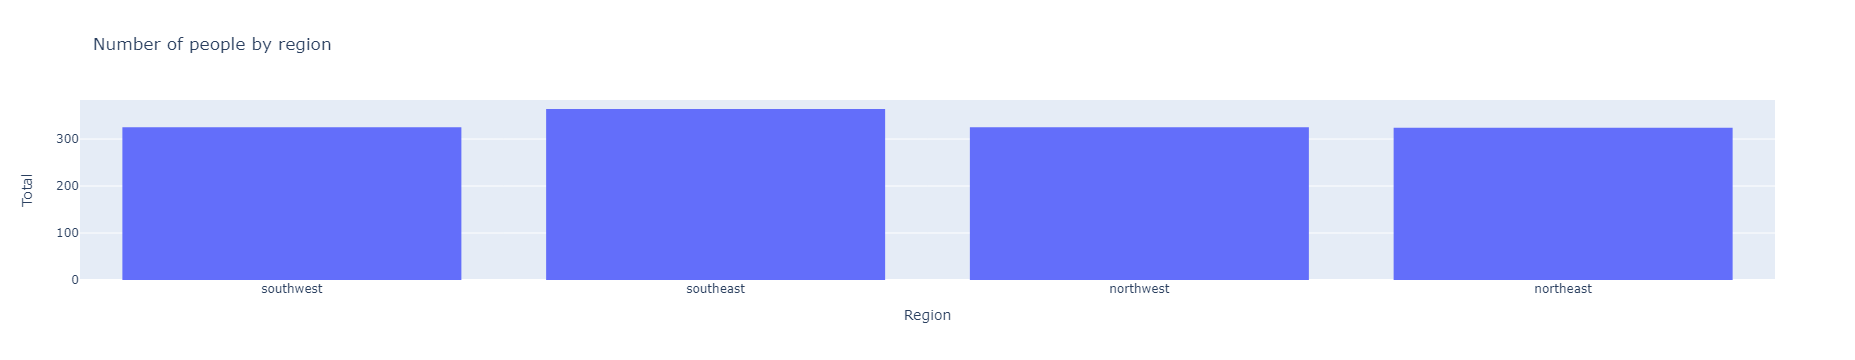

In [237]:
fig = px.histogram(df, x='region', title='Number of people by region')
fig.layout['xaxis']['title'] = 'Region'
fig.layout['yaxis']['title'] = 'Total'
fig.show()

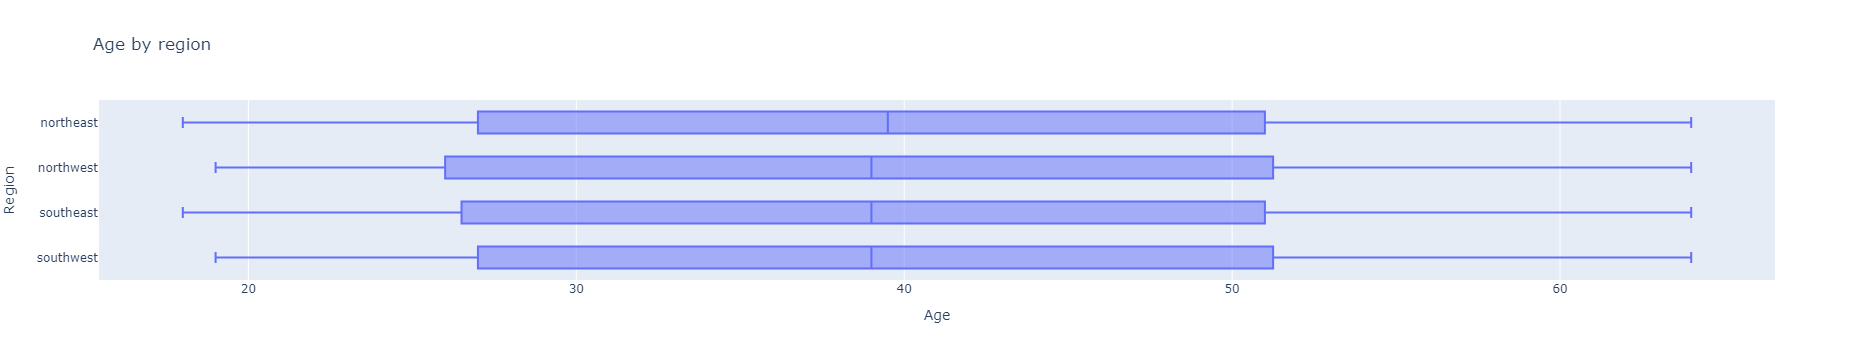

In [238]:
fig = px.box(df, y='region', x='age', orientation='h', title='Age by region')
fig.layout['xaxis']['title'] = 'Age'
fig.layout['yaxis']['title'] = 'Region'
fig.show()

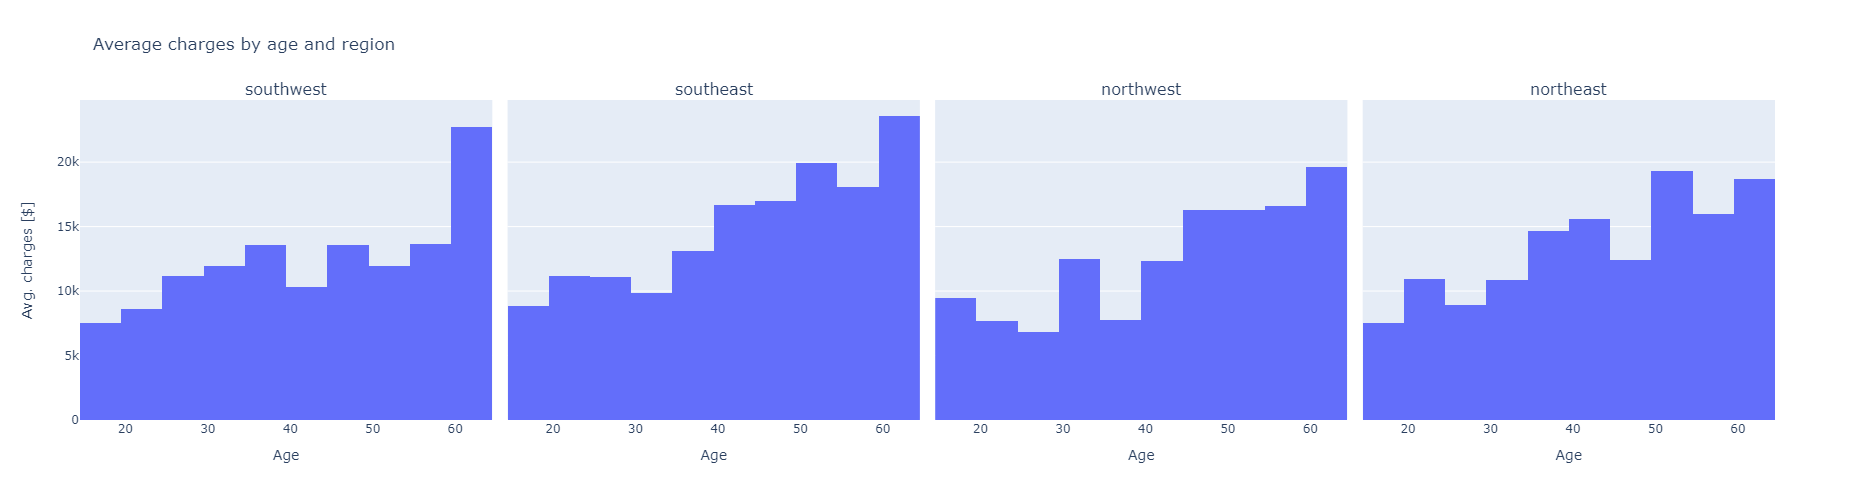

In [164]:
figures = [   ]
regions = df.region.unique()
for r in regions:
    figures.append(px.histogram(df.loc[df['region']==r], x='age', y='charges', histfunc='avg', nbins=10))
    
fig = sp.make_subplots(rows=1, cols=4, shared_yaxes=True, subplot_titles=(regions), horizontal_spacing=0.009)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i+1)
        
fig.update_yaxes(title_text="Avg. charges [$]",  row=1, col=1)
fig.update_xaxes(title_text="Age")


fig.layout['legend']['title']['text'] = 'Sex'
fig.update_layout(
    title_text="Average charges by age and region",
    height=500
)

fig.show()

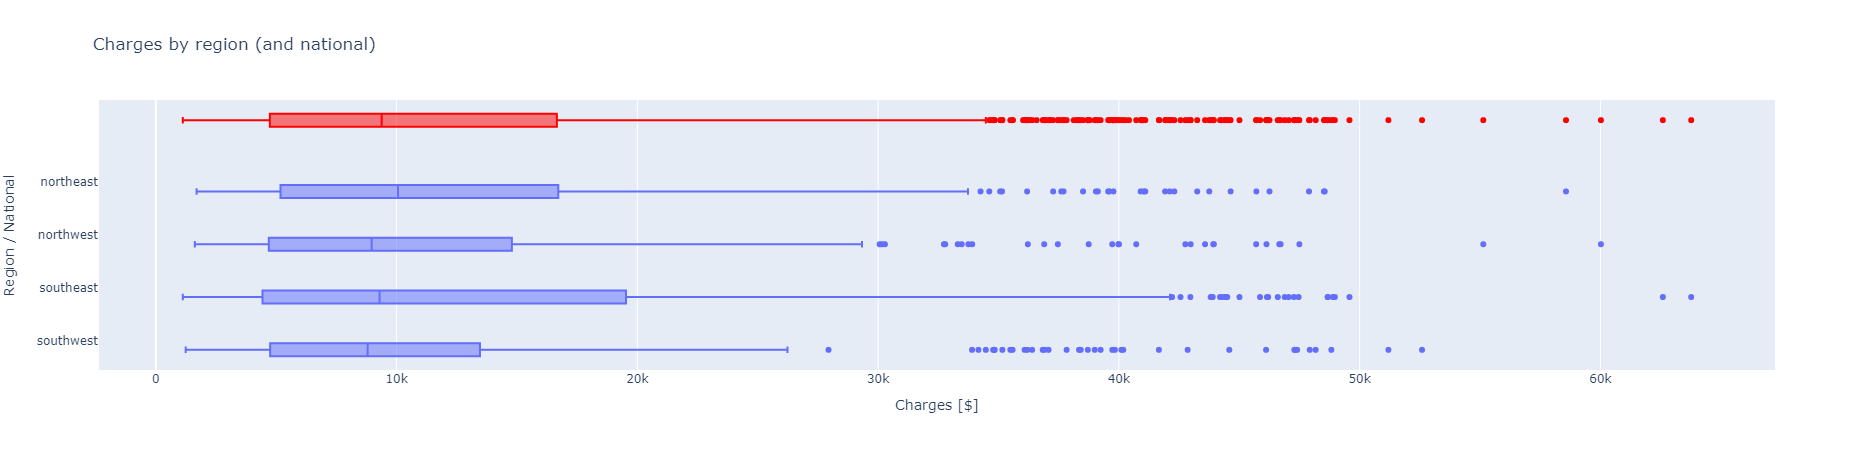

In [206]:
fig = px.box(df, x='charges', y='region', orientation='h', title='Charges by region (and national)', height=450)
fig.add_trace(px.box(df, x='charges', color_discrete_sequence=['red'], title='National').data[0])

fig.layout['xaxis']['title'] = 'Charges [$]'
fig.layout['yaxis']['title'] = 'Region / National'
fig.show()

## Children distribution

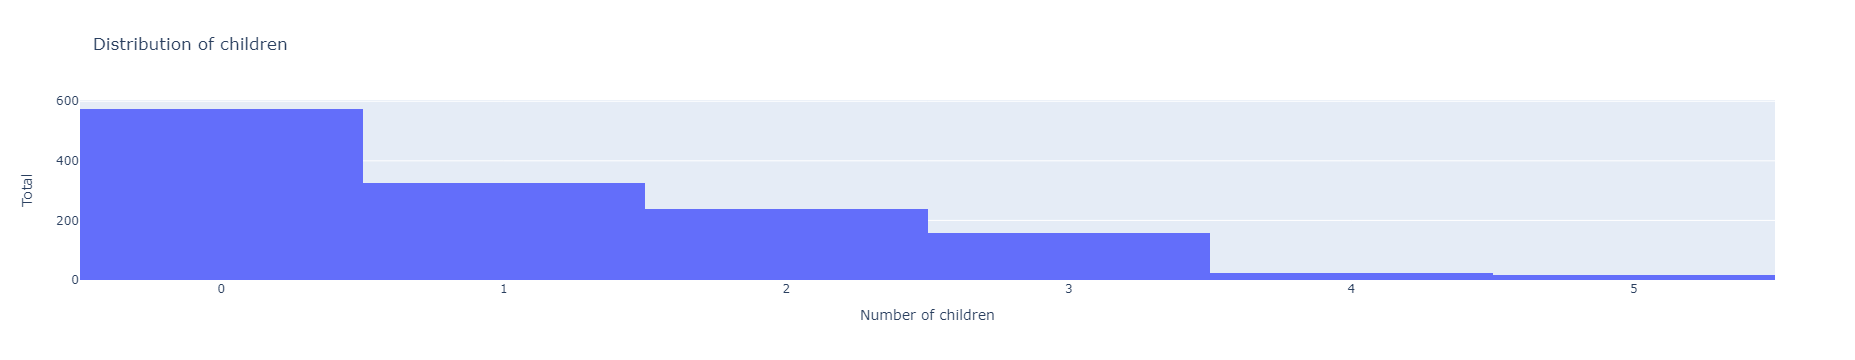

In [226]:
fig = px.histogram(df, x='children', title='Distribution of children')

fig.layout['xaxis']['title'] = 'Number of children'
fig.layout['yaxis']['title'] = 'Total'
fig.show()

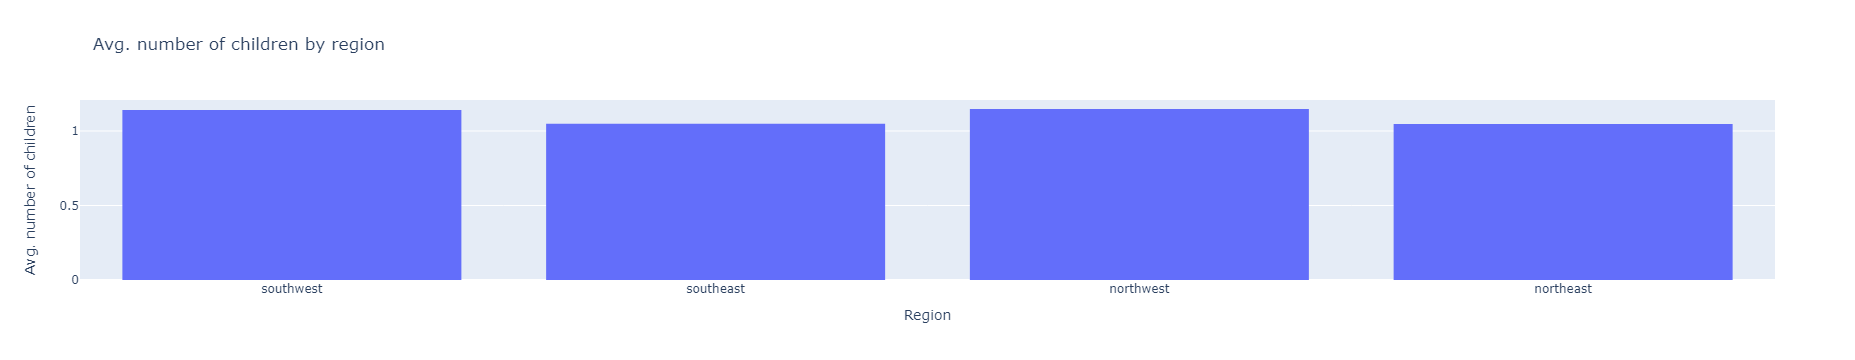

In [229]:
fig = px.histogram(df, y='children', x='region', histfunc='avg', title='Avg. number of children by region')

fig.layout['xaxis']['title'] = 'Region'
fig.layout['yaxis']['title'] = 'Avg. number of children'
fig.show()

### Impact of children on charges

According to the following analysis, no significant effect of the number of children on charges was found.

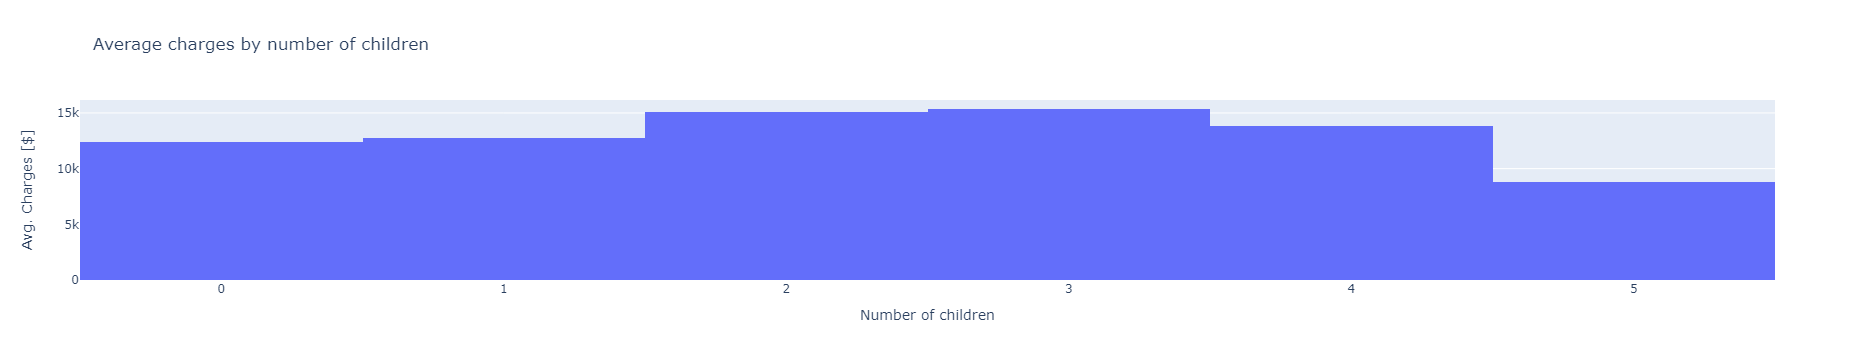

In [189]:
fig = px.histogram(df, x='children', y='charges', histfunc='avg', nbins=6, title='Average charges by number of children')
fig.layout['xaxis']['title'] = 'Number of children'
fig.layout['yaxis']['title'] = 'Avg. Charges [$]'
fig.show()

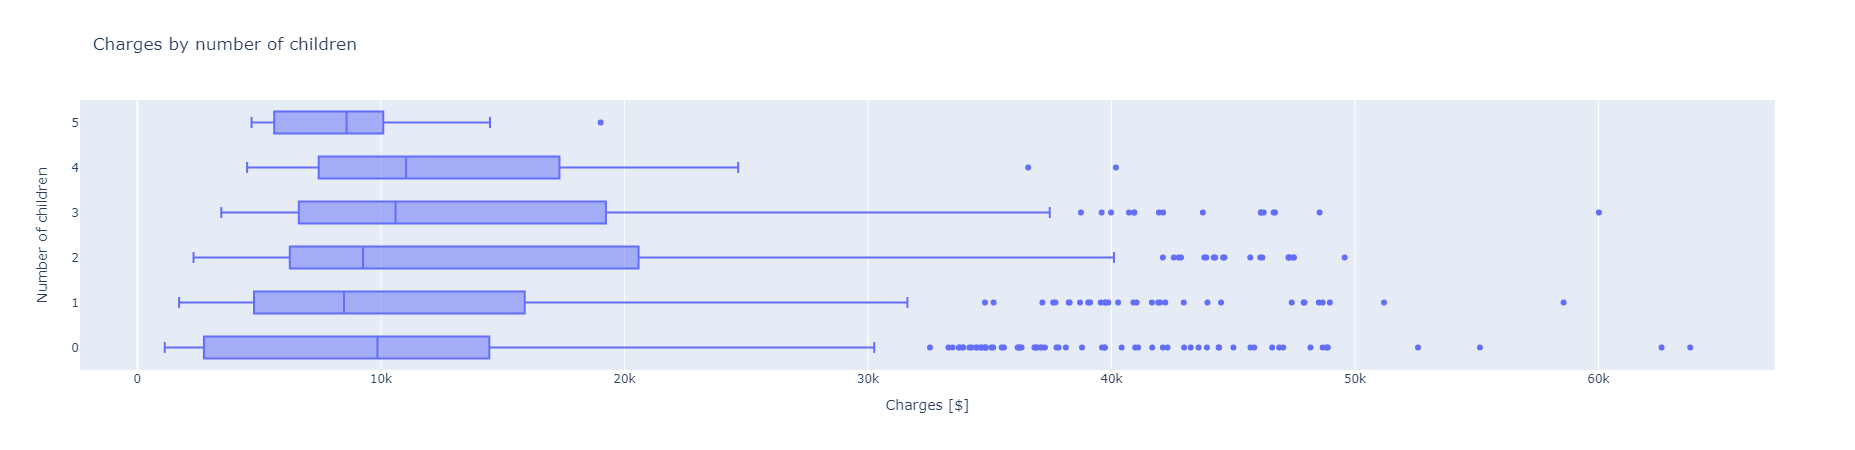

In [230]:
fig = px.box(df, x='charges', y='children', orientation='h', title='Charges by number of children')
fig.layout['xaxis']['title'] = 'Charges [$]'
fig.layout['yaxis']['title'] = 'Number of children'
fig.update_layout(height=450)
fig.show()

## Differences between men and women

The following analysis shows that no significant differences between men and women were found.

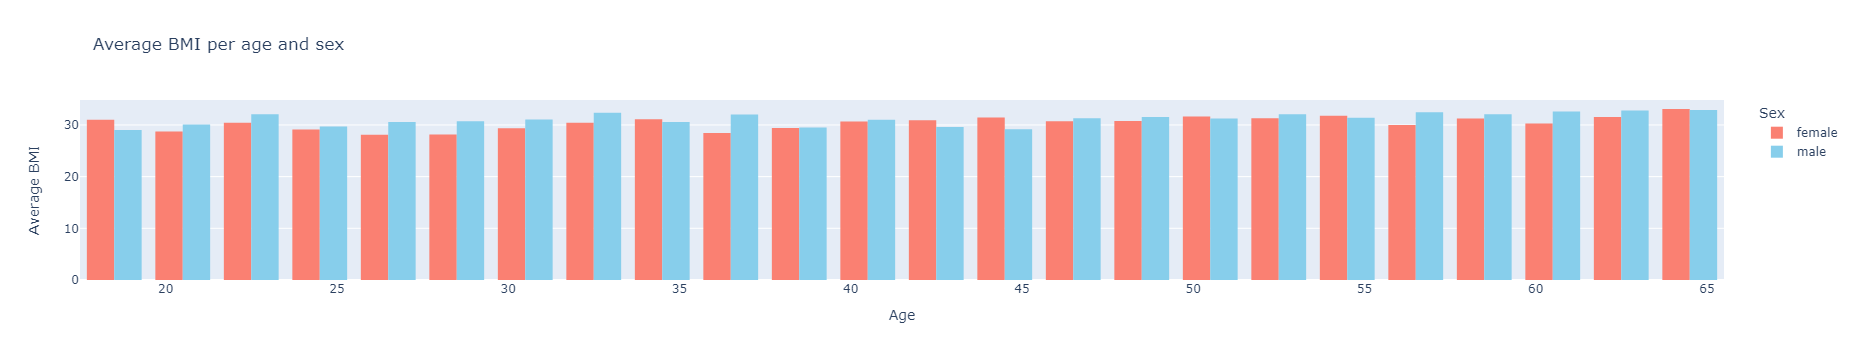

In [169]:
fig = px.histogram(df, x='age', y='bmi', color='sex', histfunc='avg', title='Average BMI per age and sex', barmode='group', color_discrete_map={'male':'skyblue', 'female':'salmon'})
fig.layout['xaxis']['title'] = 'Age'
fig.layout['yaxis']['title'] = 'Average BMI'
fig.layout['legend']['title']['text'] = 'Sex'
fig.show()

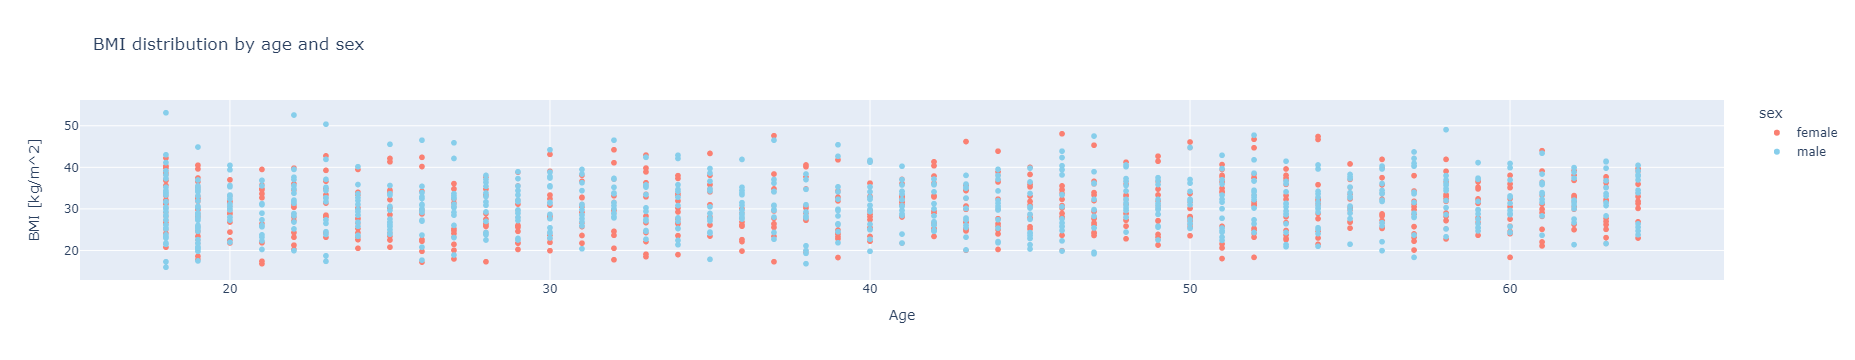

In [145]:
fig = px.scatter(df, x='age', y='bmi', color='sex', color_discrete_map={'male':'skyblue', 'female':'salmon'}, title='BMI distribution by age and sex')
fig.layout['xaxis']['title'] = 'Age'
fig.layout['yaxis']['title'] = 'BMI [kg/m^2]'
fig.show()

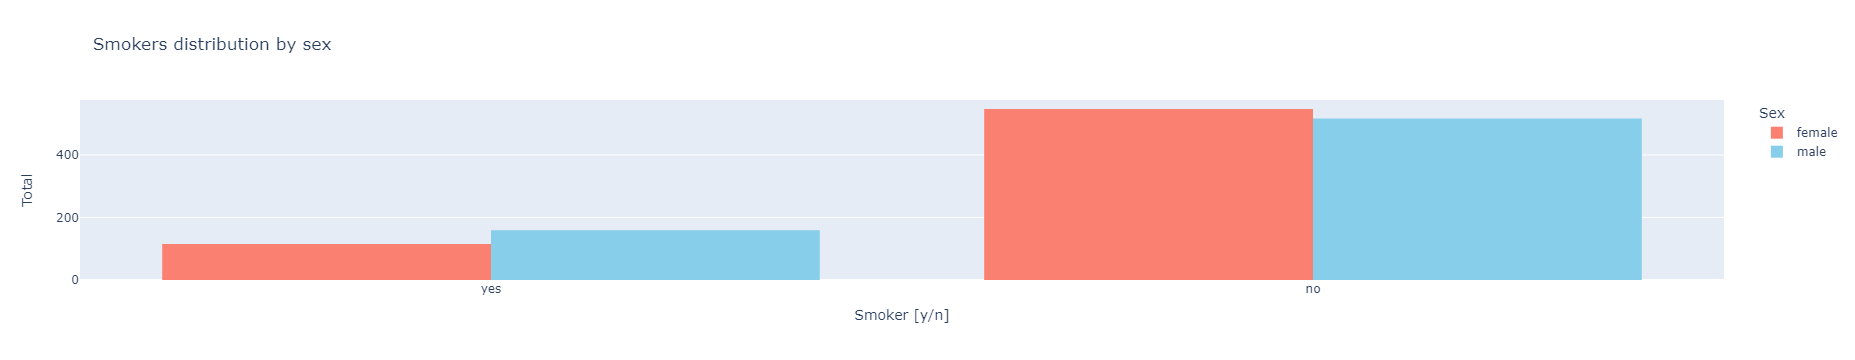

In [25]:
fig = px.histogram(df, x='smoker', color='sex', barmode='group', color_discrete_map={'female':'salmon', 'male':'skyblue'}, title = 'Smokers distribution by sex')

fig.layout['xaxis']['title'] = 'Smoker [y/n]'
fig.layout['yaxis']['title'] = 'Total'
fig.layout['legend']['title']['text'] = 'Sex'
fig.show()

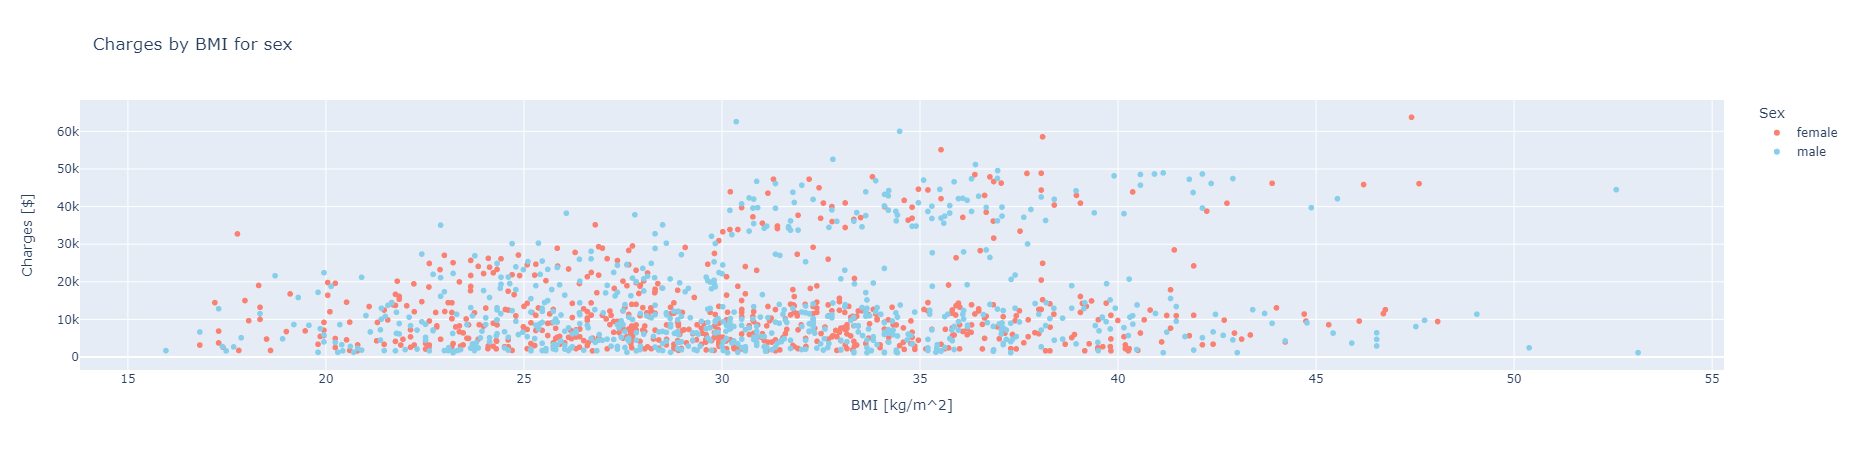

In [167]:
fig = px.scatter(df, x='bmi', y='charges', color='sex', color_discrete_map={'female':'salmon', 'male':'skyblue'}, title='Charges by BMI for sex', height=450)

fig.layout['xaxis']['title'] = 'BMI [kg/m^2]'
fig.layout['yaxis']['title'] = 'Charges [$]'
fig.layout['legend']['title']['text'] = 'Sex'

fig.show()

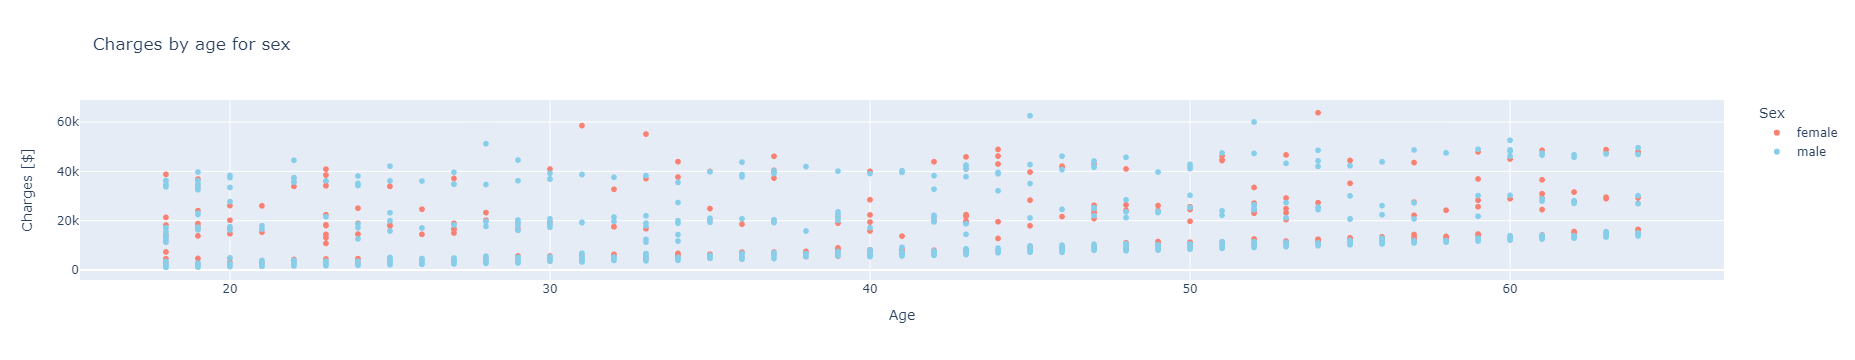

In [168]:
fig = px.scatter(df, x='age', y='charges',color='sex', color_discrete_map={'female':'salmon', 'male':'skyblue'}, title='Charges by age for sex')

fig.layout['yaxis']['title'] = 'Charges [$]'
fig.layout['xaxis']['title'] = 'Age'
fig.layout['legend']['title']['text'] = 'Sex'

fig.show()

## Smoking effects on charges

The following analysis shows that smoking appears to have high effects on a person's medical charges. 

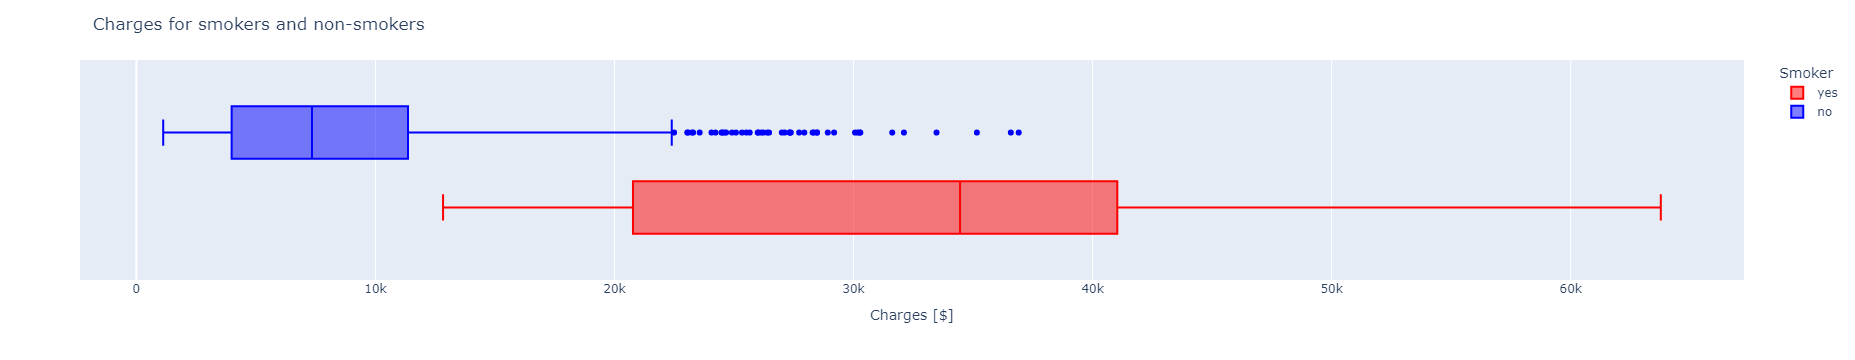

In [194]:
fig = px.box(df, x='charges', color='smoker', orientation='h', color_discrete_map={'yes':'red', 'no':'blue'})

fig.layout['title'] = 'Charges for smokers and non-smokers'
fig.layout['xaxis']['title'] = 'Charges [$]'
fig.layout['legend']['title']['text'] = 'Smoker'

fig.show()

Regardless of the age and BMI index values, it is evident that the charges for smokers are higher than those for non-smokers. 

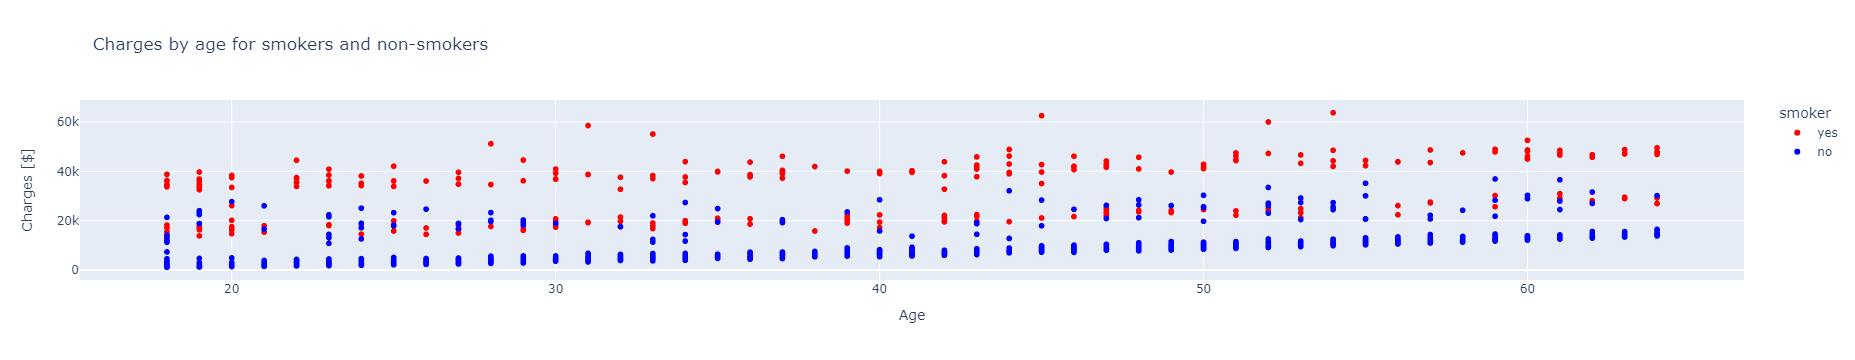

In [191]:
fig = px.scatter(df, x='age', y='charges',color='smoker', color_discrete_map={'yes':'red', 'no':'blue'}, title='Charges by age for smokers and non-smokers')

fig.layout['yaxis']['title'] = 'Charges [$]'
fig.layout['xaxis']['title'] = 'Age'

fig.show()

Starting from a BMI value of 30 (which is considered the threshold for obesity), smokers face a substantial increase in charges, rising from approximately \\$25k to over \\$40k. \
This suggests that obese smokers tend to have even higher medical charges.

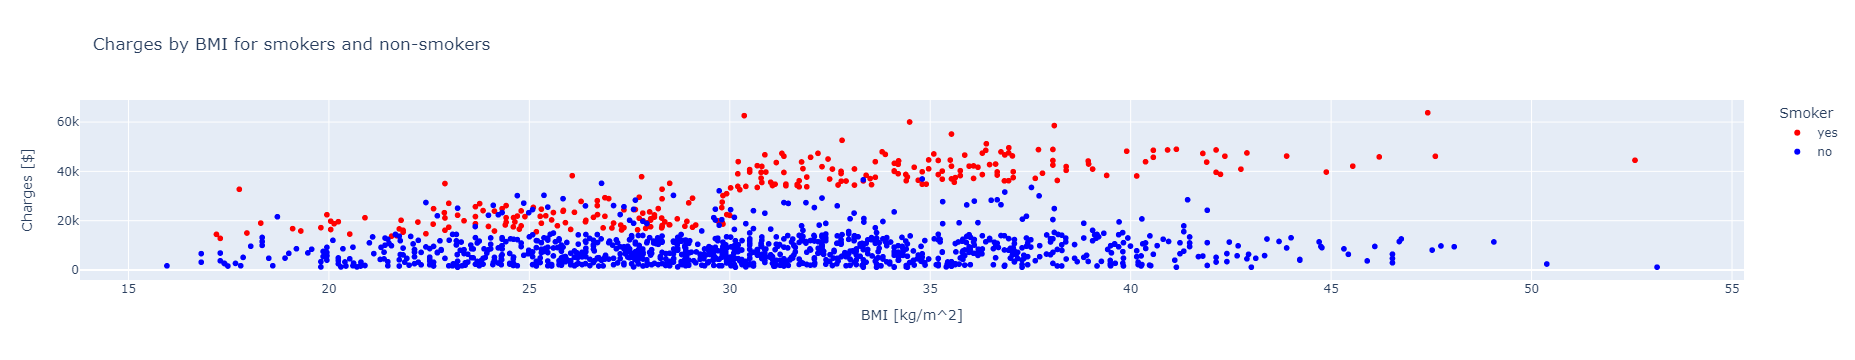

In [197]:
fig = px.scatter(df, x='bmi', y='charges', color='smoker', color_discrete_map={'yes':'red', 'no':'blue'}, title='Charges by BMI for smokers and non-smokers')

fig.layout['xaxis']['title'] = 'BMI [kg/m^2]'
fig.layout['yaxis']['title'] = 'Charges [$]'
fig.layout['legend']['title']['text'] = 'Smoker'

fig.show()

# ML Analysis

## Support Methods

In [292]:
def prepareData(get_dummies=True, dummy_cols = ['sex', 'smoker', 'region'], get_encoded_labels = False, encoded_label_cols = ['region']):
    df = load_data()
    
    encoded_labels = {}
    if get_encoded_labels:
        enc = LabelEncoder()
        
        for c in encoded_label_cols:
            col_label = f'{c}_enc'
            df[col_label] = ''
            label_names=np.array(list(set(df[c])))
            enc.fit(np.array(label_names))
            df[col_label] = enc.transform(df[c])
            encoded_labels[c] = label_names
    
    if get_dummies:
        dummies = []
        
        for c in dummy_cols:      
            
            if get_encoded_labels and c in encoded_label_cols:
                continue
            
            dummy = pd.get_dummies(df[c], drop_first=True)
            
            if c == 'smoker':
                dummy = dummy.rename(columns={"yes": 'smokes'})
                
            dummies.append(dummy)
            
        _df = pd.concat([x for x in dummies],axis=1)
        df = pd.concat([df, _df],axis=1)
        df = df.drop(dummy_cols, axis=1)
            
    if get_encoded_labels:
        return df, encoded_labels
    return df

In [253]:
def Adj_R2(r2, obs, var_no):
    return 1 - ((1-r2)*(len(obs)-1)/(len(obs)-var_no-1))

In [260]:
def k_fold(reg, Xs, y, scoring_type='neg_mean_squared_error', cvs=5):
    return -np.mean(cross_val_score(reg, Xs, y, scoring=scoring_type, cv=cvs))

In [255]:
def split(cols, target=['charges'], test_size=0.2, split_val=False, val_size=0.3, scale=True, poly_degree=1, random_state=1492):

    n_cols = len(cols)

    x_train, x_test, y_train, y_test = train_test_split(df[cols], df[target], test_size=test_size, random_state=random_state)
    
    if split_val:
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=random_state)
    
    
    if poly_degree > 1:
        poly = PolynomialFeatures(degree=poly_degree)
        x_train = poly.fit_transform(x_train)
        x_test = poly.transform(x_test)
        
        if split_val:
            x_val = poly.transform(x_val)

    if scale:
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
        
        if split_val:
            x_val = scaler.transform(x_val)
            
    y_train = y_train.values.reshape(-1, 1).ravel()
    y_test = y_test.values.reshape(-1, 1).ravel()
    
    if split_val:
        y_val = y_val.values.ravel()

    
    if split_val:
        return x_train, y_train, x_val, y_val, x_test, y_test, n_cols
    else:
        return x_train, y_train, x_test, y_test, n_cols

In [262]:
def print_reg_stats(reg, x_train, y_train, x_test, y_test, already_trained=False):
    n_cols = x_train.shape[1]
    
    if not already_trained:
        reg.fit(x_train, y_train)
    
    y_train_predicted = reg.predict(x_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    print(f'TRAIN RMSE:         \t {train_rmse}') 

    train_r2 = reg.score(x_train, y_train)
    print(f'TRAIN R2 score:     \t {train_r2}')
    print(f'TRAIN Adj R2 score: \t {Adj_R2(train_r2, x_train, n_cols)}')

    print()

    y_test_predicted = reg.predict(x_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predicted))
    print(f'TEST RMSE:          \t {test_rmse}') 

    test_r2 = reg.score(x_test, y_test)
    print(f'TEST R2 score:      \t {test_r2}')
    test_r2_adj = Adj_R2(test_r2, x_test, n_cols)
    print(f'TEST Adj R2 score:  \t {test_r2_adj}')
    
    return test_rmse, test_r2, test_r2_adj

<Axes: >

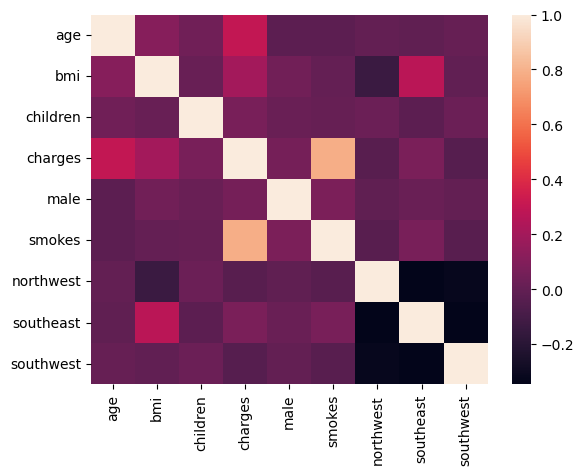

In [371]:
corr_matrix = df.corr()

sb.heatmap(corr_matrix)

In [370]:
for c in df.columns:
    if (c != 'sex'):
        print(corr_matrix[c].sort_values(ascending = False))
        print()

age          1.000000
charges      0.299008
bmi          0.109272
children     0.042469
southwest    0.010016
northwest   -0.000407
southeast   -0.011642
male        -0.020856
smokes      -0.025019
Name: age, dtype: float64

bmi          1.000000
southeast    0.270025
charges      0.198341
age          0.109272
male         0.046371
children     0.012759
smokes       0.003750
southwest   -0.006205
northwest   -0.135996
Name: bmi, dtype: float64

children     1.000000
charges      0.067998
age          0.042469
northwest    0.024806
southwest    0.021914
male         0.017163
bmi          0.012759
smokes       0.007673
southeast   -0.023066
Name: children, dtype: float64

charges      1.000000
smokes       0.787251
age          0.299008
bmi          0.198341
southeast    0.073982
children     0.067998
male         0.057292
northwest   -0.039905
southwest   -0.043210
Name: charges, dtype: float64

male         1.000000
smokes       0.076185
charges      0.057292
bmi          0.046371
chi

## CLASSIFICATION - Predict if smoker or not

In [266]:
f1_scores_smoker = {}

### Logistic Regression

In [314]:
df = prepareData(get_dummies=True)

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges'], ['smokes'], scale=True)

reg = LogisticRegression()

reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['no','yes']))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_smoker['Logistic Regression'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.98      0.97      0.98       215
         yes       0.89      0.92      0.91        53

    accuracy                           0.96       268
   macro avg       0.94      0.95      0.94       268
weighted avg       0.96      0.96      0.96       268


[[209   6]
 [  4  49]]


In [315]:
df = prepareData(get_dummies=True)

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges'], ['smokes'], scale=True, poly_degree=2)

reg = LogisticRegression()

reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['no','yes']))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_smoker['Logistic Regression - Poly 2'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.99      0.97      0.98       215
         yes       0.89      0.94      0.92        53

    accuracy                           0.97       268
   macro avg       0.94      0.96      0.95       268
weighted avg       0.97      0.97      0.97       268


[[209   6]
 [  3  50]]


### Support Vector Machines

In [316]:
df = prepareData(get_dummies=True)

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges'], ['smokes'], scale=True)

reg = SVC()

reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['no','yes']))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_smoker['SVM'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          no       1.00      0.96      0.98       215
         yes       0.85      1.00      0.92        53

    accuracy                           0.97       268
   macro avg       0.93      0.98      0.95       268
weighted avg       0.97      0.97      0.97       268


[[206   9]
 [  0  53]]


In [317]:
df = prepareData(get_dummies=True)

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges'], ['smokes'], scale=True, poly_degree=2)

reg = SVC()

reg.fit(x_train, y_train)


y_pred = reg.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['no','yes']))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_smoker['SVM - Poly 2'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          no       1.00      0.95      0.98       215
         yes       0.84      1.00      0.91        53

    accuracy                           0.96       268
   macro avg       0.92      0.98      0.94       268
weighted avg       0.97      0.96      0.96       268


[[205  10]
 [  0  53]]


### K-Nearest Neighbours

              precision    recall  f1-score   support

          no       1.00      0.96      0.98       215
         yes       0.85      0.98      0.91        53

    accuracy                           0.96       268
   macro avg       0.92      0.97      0.94       268
weighted avg       0.97      0.96      0.96       268



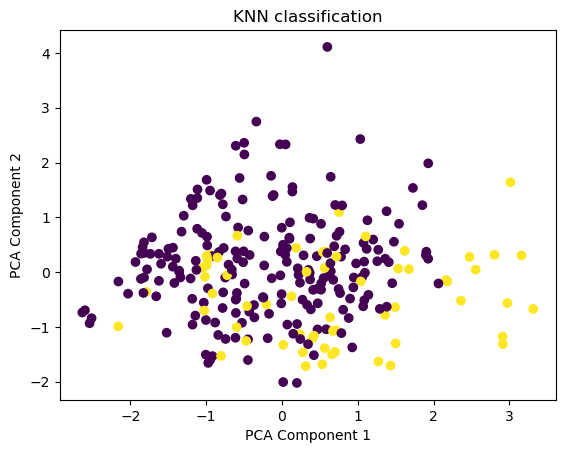


[[206   9]
 [  1  52]]


In [319]:
df = prepareData(get_dummies=True)

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges'], ['smokes'], scale=True)

reg = KNeighborsClassifier()

reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['no','yes']))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_test)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KNN classification')
plt.show()

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_smoker['KNN'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          no       1.00      0.96      0.98       215
         yes       0.85      0.98      0.91        53

    accuracy                           0.96       268
   macro avg       0.92      0.97      0.94       268
weighted avg       0.97      0.96      0.96       268



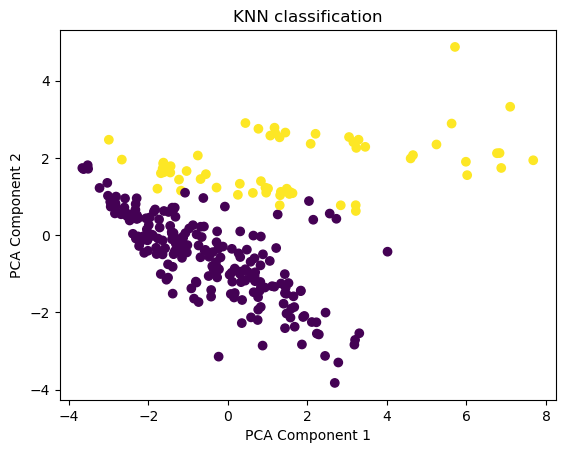


[[206   9]
 [  1  52]]


In [320]:
df = prepareData(get_dummies=True)

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges'], ['smokes'], scale=True, poly_degree=2)

reg = KNeighborsClassifier()

reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['no','yes']))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_test)

# Plot the predictions on a scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KNN classification')
plt.show()

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_smoker['KNN - Poly 2'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

### Results

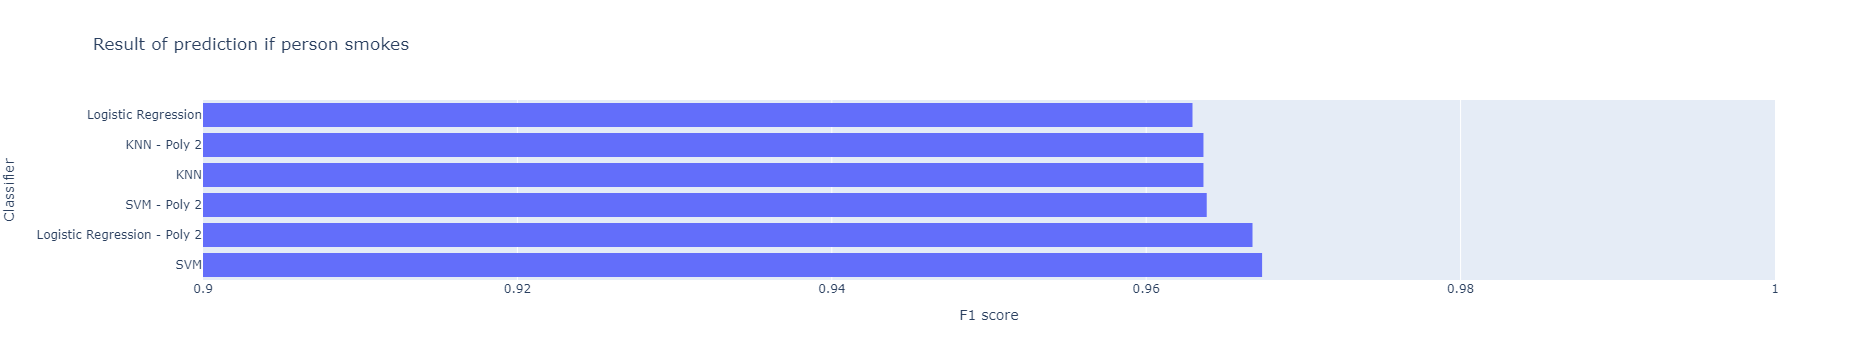

In [305]:
sorted_f1 = dict(sorted(f1_scores_smoker.items(), key=lambda item: item[1], reverse=True))

fig = px.histogram(y=list(sorted_f1.keys()), x=list(sorted_f1.values()), orientation='h', title='Result of prediction if person smokes')

fig.layout['xaxis']['title'] = 'F1 score'
fig.layout['yaxis']['title'] = 'Classifier'
fig.update_xaxes(range=[0.90, 1])

## CLASSIFICATION - Predict sex

In [278]:
f1_scores_sex = {}

### Lasso for variable condensing

The following analysis suggests that none of the attributes are highly correlated with the person's sex.

Text(0, 0.5, 'weights')

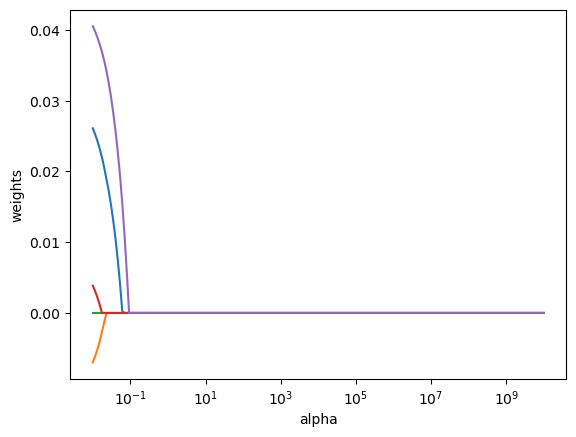

In [395]:
df, labels = prepareData(get_dummies=True, dummy_cols = ['smoker'], get_encoded_labels = True, encoded_label_cols = ['sex'])

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges', 'children', 'smokes'], ['sex_enc'], scale=True)

lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

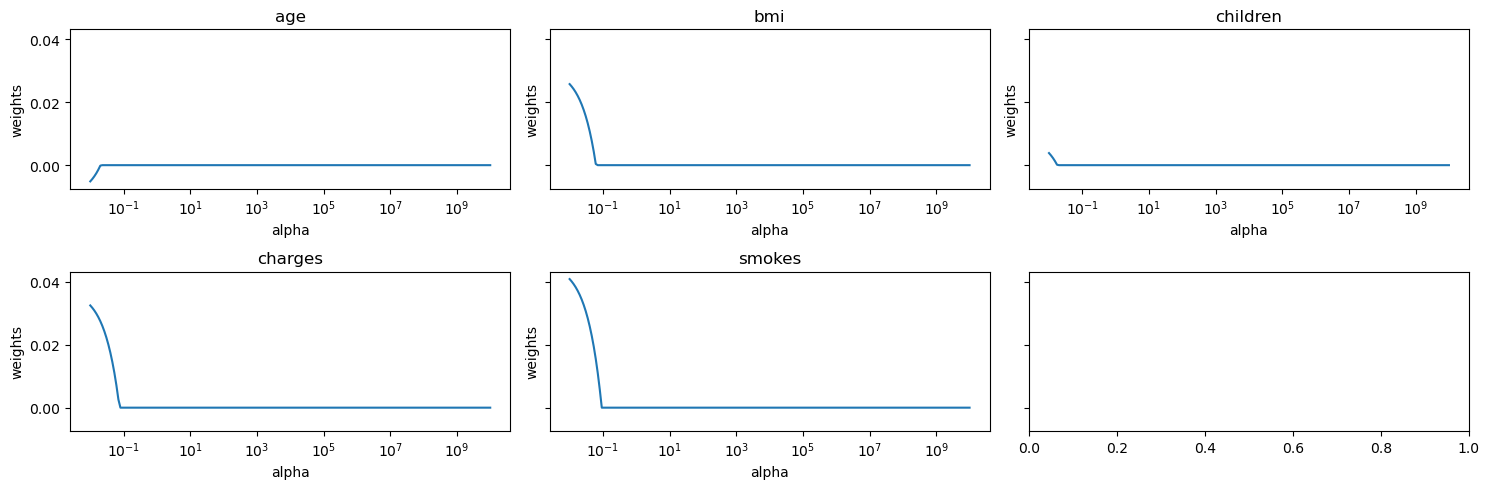

In [396]:
alphas = 10**np.linspace(10,-2,200)*0.5

columns = df.drop(['sex_enc', 'sex','region',], axis=1).columns

plot_cols = math.ceil(len(columns)/2.0)
fig, axes = plt.subplots(nrows=2, ncols=plot_cols, figsize=(15, 5), sharey=True)
i = 0
j = 0
for c in (columns):
    
    x_train, y_train, x_test, y_test, n_cols = split([c], ['sex_enc'])
    lasso = Lasso(max_iter = 10000)
    coefs = []
    
    for a in alphas:
        lasso.set_params(alpha=a)
        lasso.fit(x_train, y_train)
        coefs.append(lasso.coef_[0])
    
    ax = axes[i, j]
    ax.plot(alphas*2, coefs)
    ax.set_xscale('log')
    ax.set_yscale('linear')
    ax.set_title(c)
    ax.set_xlabel('alpha')
    ax.set_ylabel('weights')
    
    j += 1
    if j >= plot_cols:
        i += 1
        j = 0

plt.tight_layout()
plt.show()

### Support Vector Machines

In [321]:
df, label_names = prepareData(get_dummies=True, dummy_cols = ['smoker'], get_encoded_labels=True, encoded_label_cols=['region','sex'])

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges', 'smokes'], ['sex_enc'], scale=True, poly_degree=2)

reg = SVC()

reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(label_names['sex'])))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_sex['SVC - Poly 2'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

      female       0.49      0.65      0.56       130
        male       0.52      0.35      0.42       138

    accuracy                           0.50       268
   macro avg       0.50      0.50      0.49       268
weighted avg       0.50      0.50      0.48       268


[[85 45]
 [90 48]]


### K-Nearest Neighbours

              precision    recall  f1-score   support

      female       0.49      0.50      0.49       130
        male       0.51      0.50      0.51       138

    accuracy                           0.50       268
   macro avg       0.50      0.50      0.50       268
weighted avg       0.50      0.50      0.50       268


[[65 65]
 [69 69]]


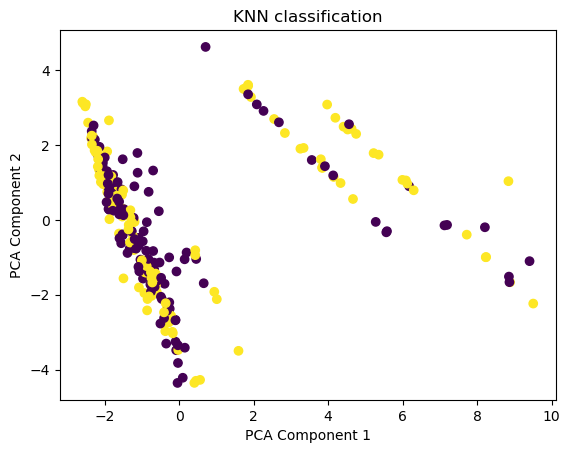

In [313]:
df, label_names = prepareData(get_dummies=True, dummy_cols = ['smoker'], get_encoded_labels=True, encoded_label_cols=['sex'])

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges', 'smokes'], ['sex_enc'], scale=True, poly_degree=2)

reg = KNeighborsClassifier()

reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(label_names['sex'])))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_sex['KNN - Poly 2'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_test)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KNN classification')
plt.show()

### Logistic Regression

In [312]:
df, label_names = prepareData(get_dummies=True, dummy_cols = ['smoker'], get_encoded_labels=True, encoded_label_cols=['region','sex'])

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges', 'smokes'], ['sex_enc'], scale=True, poly_degree=2)

reg = LogisticRegression()

reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(label_names['sex'])))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_sex['Logistic Regression - Poly 2'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

      female       0.52      0.64      0.57       130
        male       0.56      0.44      0.50       138

    accuracy                           0.54       268
   macro avg       0.54      0.54      0.53       268
weighted avg       0.54      0.54      0.53       268


[[83 47]
 [77 61]]


### Random Forest Classifier 

In [322]:
df, label_names = prepareData(get_dummies=True, dummy_cols = ['smoker'], get_encoded_labels=True, encoded_label_cols=['sex'])

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges', 'smokes'], ['sex_enc'], scale=True, poly_degree=2)

reg = RandomForestClassifier()

reg.fit(x_train, y_train)

y_pred = reg.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(label_names['sex'])))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_sex['Random Forest - Poly 2'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

      female       0.54      0.61      0.57       130
        male       0.58      0.51      0.55       138

    accuracy                           0.56       268
   macro avg       0.56      0.56      0.56       268
weighted avg       0.56      0.56      0.56       268


[[79 51]
 [67 71]]


### Results

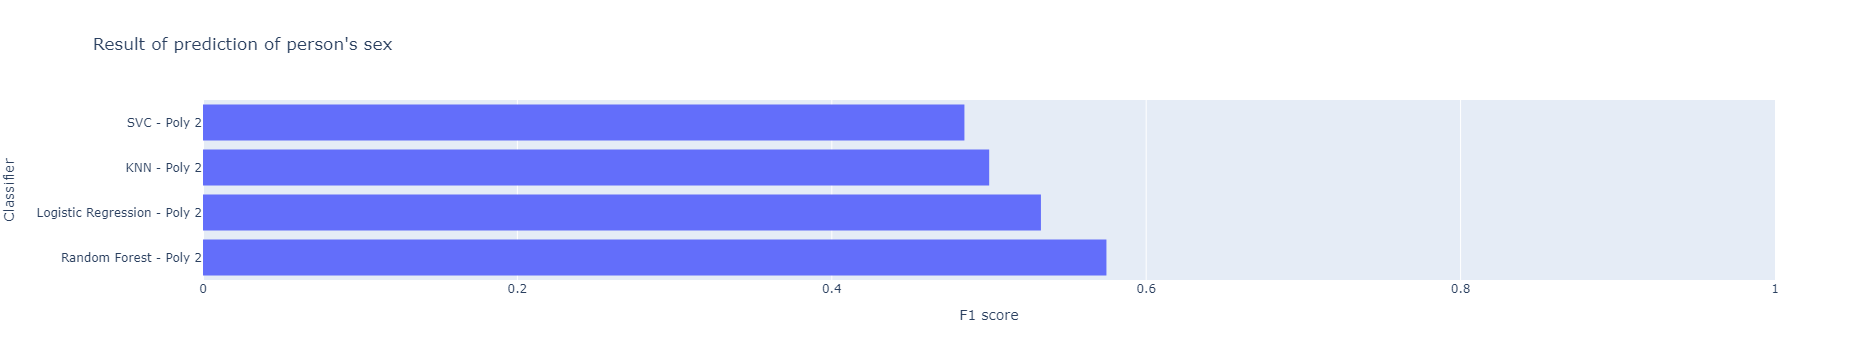

In [298]:
sorted_f1 = dict(sorted(f1_scores_sex.items(), key=lambda item: item[1], reverse=True))

fig = px.histogram(y=list(sorted_f1.keys()), x=list(sorted_f1.values()), orientation='h', title='Result of prediction of person\'s sex')

fig.layout['xaxis']['title'] = 'F1 score'
fig.layout['yaxis']['title'] = 'Classifier'

fig.update_xaxes(range=[0, 1])

## CLASSIFICATION - Predict region

In [387]:
f1_scores_region = {}

### Lasso for variable condensing 

The following analysis suggests that none of the attributes are highly correlated with the region.

Text(0, 0.5, 'weights')

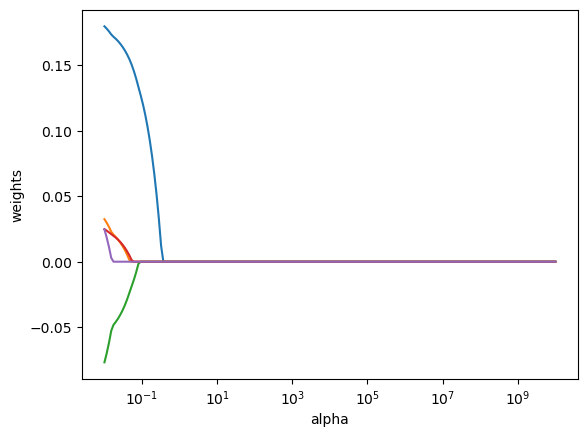

In [385]:
df, labels = prepareData(get_dummies=True, dummy_cols = ['sex', 'smoker'], get_encoded_labels = True, encoded_label_cols = ['region'])

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges', 'children', 'smokes'], ['region_enc'], scale=True)

lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

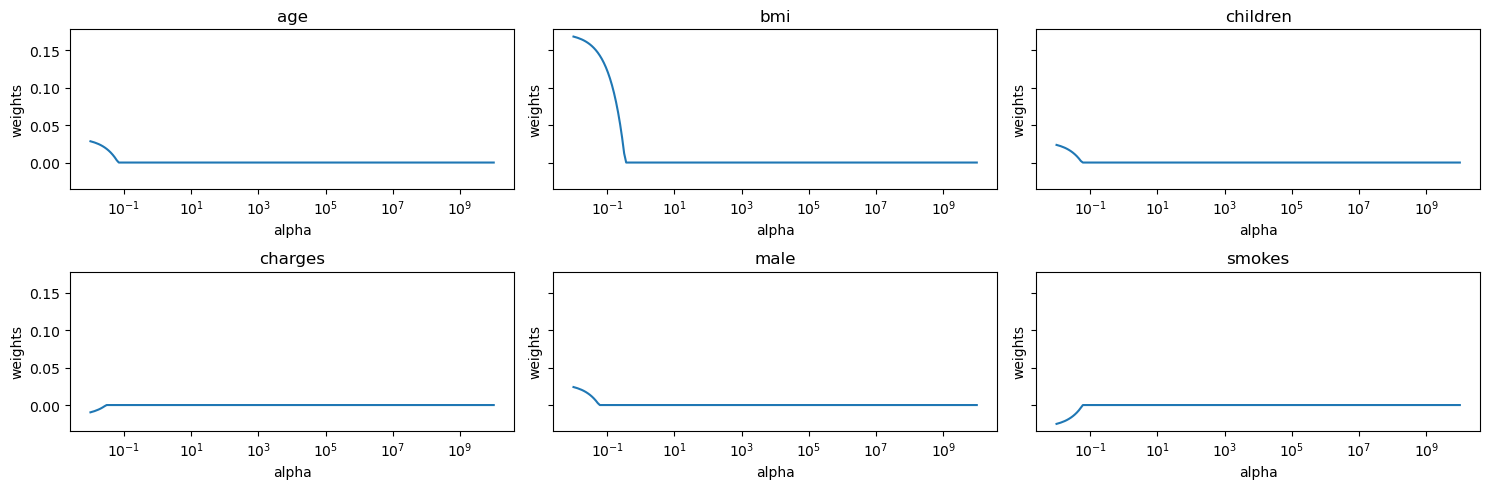

In [386]:
alphas = 10**np.linspace(10,-2,200)*0.5

columns = df.drop(['region_enc', 'region',], axis=1).columns
plot_cols = math.ceil(len(columns)/2.0)
fig, axes = plt.subplots(nrows=2, ncols=plot_cols, figsize=(15, 5), sharey=True)
i = 0
j = 0
for c in (columns):
    
    x_train, y_train, x_test, y_test, n_cols = split([c], 'region_enc')
    lasso = Lasso(max_iter = 10000)
    coefs = []
    
    for a in alphas:
        lasso.set_params(alpha=a)
        lasso.fit(x_train, y_train)
        coefs.append(lasso.coef_[0])
    
    ax = axes[i, j]
    ax.plot(alphas*2, coefs)
    ax.set_xscale('log')
    ax.set_yscale('linear')
    ax.set_title(c)
    ax.set_xlabel('alpha')
    ax.set_ylabel('weights')
    
    j += 1
    if j >= plot_cols:
        i += 1
        j = 0

plt.tight_layout()
plt.show()

### Logistic Regression

In [323]:
df, label_names = prepareData(get_dummies=True, dummy_cols = ['smoker','sex'], get_encoded_labels=True, encoded_label_cols=['region'])

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges', 'smokes', 'male'], ['region_enc'], scale=True)

reg = LogisticRegression(multi_class='ovr')

reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

print(classification_report(y_test, y_pred, target_names=list(label_names['region'])))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_region['Logistic Regression'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

   southeast       0.26      0.45      0.33        56
   northeast       0.30      0.13      0.18        63
   southwest       0.34      0.46      0.39        80
   northwest       0.20      0.10      0.13        69

    accuracy                           0.29       268
   macro avg       0.27      0.28      0.26       268
weighted avg       0.28      0.29      0.26       268


[[25  2 19 10]
 [26  8 16 13]
 [27 11 37  5]
 [18  6 38  7]]


### One vs One - Logistic Regression

In [330]:
df, label_names = prepareData(get_dummies=True, dummy_cols = ['smoker','sex'], get_encoded_labels=True, encoded_label_cols=['region'])

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges', 'smokes', 'male'], ['region_enc'], scale=True)

clf = OneVsOneClassifier(LogisticRegression())

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(label_names['region'])))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_region['One vs One - Logistic Reg.'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

   southeast       0.26      0.43      0.33        56
   northeast       0.30      0.14      0.19        63
   southwest       0.35      0.46      0.40        80
   northwest       0.25      0.14      0.18        69

    accuracy                           0.30       268
   macro avg       0.29      0.29      0.27       268
weighted avg       0.29      0.30      0.28       268


[[24  3 19 10]
 [24  9 16 14]
 [25 12 37  6]
 [18  6 35 10]]


### K-Nearest Neighbours

In [324]:
df, label_names = prepareData(get_dummies=True, dummy_cols = ['smoker','sex'], get_encoded_labels=True, encoded_label_cols=['region'])

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges', 'children', 'smokes'], ['region_enc'], scale=True)

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(label_names['region'])))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_region['KNN'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

   southeast       0.23      0.41      0.30        56
   northeast       0.29      0.27      0.28        63
   southwest       0.31      0.24      0.27        80
   northwest       0.25      0.17      0.21        69

    accuracy                           0.26       268
   macro avg       0.27      0.27      0.26       268
weighted avg       0.27      0.26      0.26       268


[[23 14 10  9]
 [23 17 11 12]
 [33 13 19 15]
 [20 15 22 12]]


### K-Nearest Neighbours - Grid Search CV

              precision    recall  f1-score   support

   southeast       0.27      0.38      0.31        56
   northeast       0.31      0.29      0.30        63
   southwest       0.41      0.33      0.36        80
   northwest       0.22      0.22      0.22        69

    accuracy                           0.30       268
   macro avg       0.30      0.30      0.30       268
weighted avg       0.31      0.30      0.30       268


[[21  7 12 16]
 [19 18  7 19]
 [23 14 26 17]
 [16 19 19 15]]



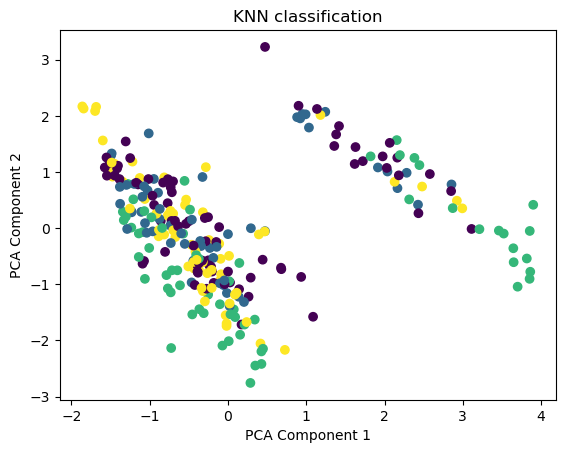

In [334]:
df, label_names = prepareData(get_dummies=True, dummy_cols = ['smoker','sex'], get_encoded_labels=True, encoded_label_cols=['region'])
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges', 'children', 'smokes'], ['region_enc'], scale=True)

param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance']}

grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(x_train, y_train)

y_pred = grid_search.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(label_names['region'])))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_region['KNN - Grid Search CV'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_test)

print()

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KNN classification')
plt.show()

### Random Forest - Grid Search CV

In [329]:
df, label_names = prepareData(get_dummies=True, dummy_cols = ['smoker','sex'], get_encoded_labels=True, encoded_label_cols=['region'])

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'charges', 'children', 'smokes'], ['region_enc'], scale=True)

param_grid = [{'n_estimators': [10, 50, 100, 125, 150, 175, 200], 'max_depth': [None, 2, 3, 4, 5, 6, 8, 10], 'random_state': [1234]}]

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)

grid_search.fit(x_train, y_train)
y_pred = grid_search.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(label_names['region'])))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_region['Random Forest - Grid Search CV'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

   southeast       0.31      0.43      0.36        56
   northeast       0.24      0.21      0.22        63
   southwest       0.38      0.29      0.33        80
   northwest       0.26      0.29      0.28        69

    accuracy                           0.30       268
   macro avg       0.30      0.30      0.30       268
weighted avg       0.30      0.30      0.30       268


[[24 12 10 10]
 [18 13  6 26]
 [20 17 23 20]
 [16 12 21 20]]


### Random Forest Classifier

In [332]:
df, label_names = prepareData(get_dummies=True, dummy_cols = ['smoker','sex'], get_encoded_labels=True, encoded_label_cols=['region'])

x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'charges', 'smokes'], ['region_enc'], scale=True)

forest_classifier = RandomForestClassifier()
forest_classifier.fit(x_train, y_train)
y_pred = forest_classifier.predict(x_test)

print(classification_report(y_test, y_pred, target_names=list(label_names['region'])))

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
f1_scores_region['Random Forest'] = f1 

print()

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

   southeast       0.32      0.45      0.37        56
   northeast       0.32      0.29      0.30        63
   southwest       0.44      0.40      0.42        80
   northwest       0.37      0.32      0.34        69

    accuracy                           0.36       268
   macro avg       0.36      0.36      0.36       268
weighted avg       0.37      0.36      0.36       268


[[25  9 11 11]
 [19 18 11 15]
 [25 11 32 12]
 [10 18 19 22]]


### Results

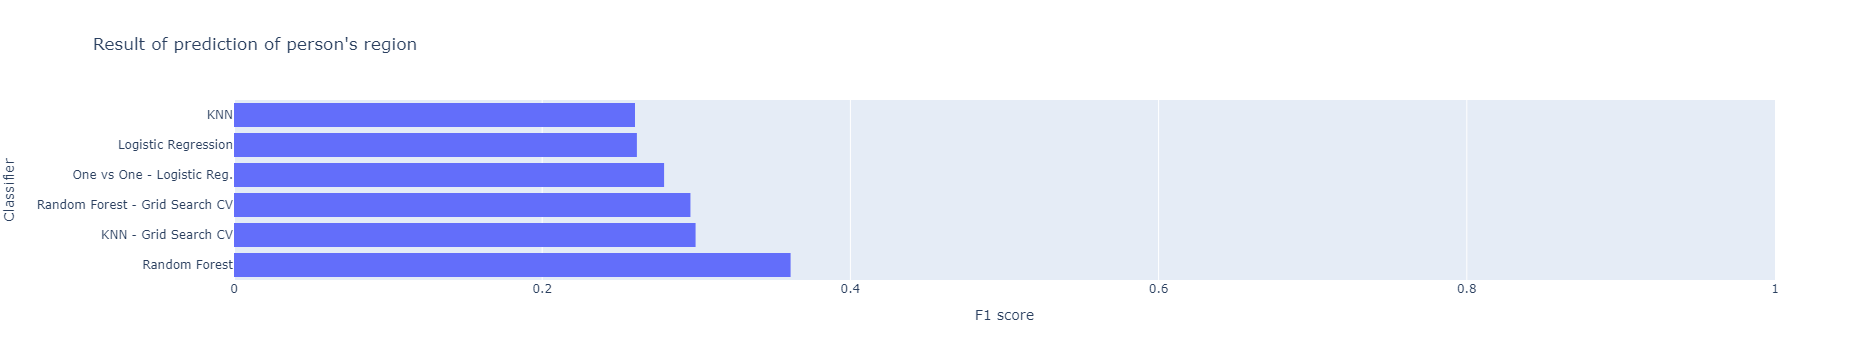

In [333]:
sorted_f1 = dict(sorted(f1_scores_region.items(), key=lambda item: item[1], reverse=True))

fig = px.histogram(y=list(sorted_f1.keys()), x=list(sorted_f1.values()), orientation='h', title='Result of prediction of person\'s region')

fig.layout['xaxis']['title'] = 'F1 score'
fig.layout['yaxis']['title'] = 'Classifier'

fig.update_xaxes(range=[0, 1])

## REGRESSION - Charges Prediction

In [397]:
df = prepareData()

result_r2 = {}
result_r2_adj = {}
result_RMSE = {}

### Lasso for variables condensing

The analysis shows that 'smokes', 'age', and 'bmi' are the attributes with the highest importance for predicting medical charges.

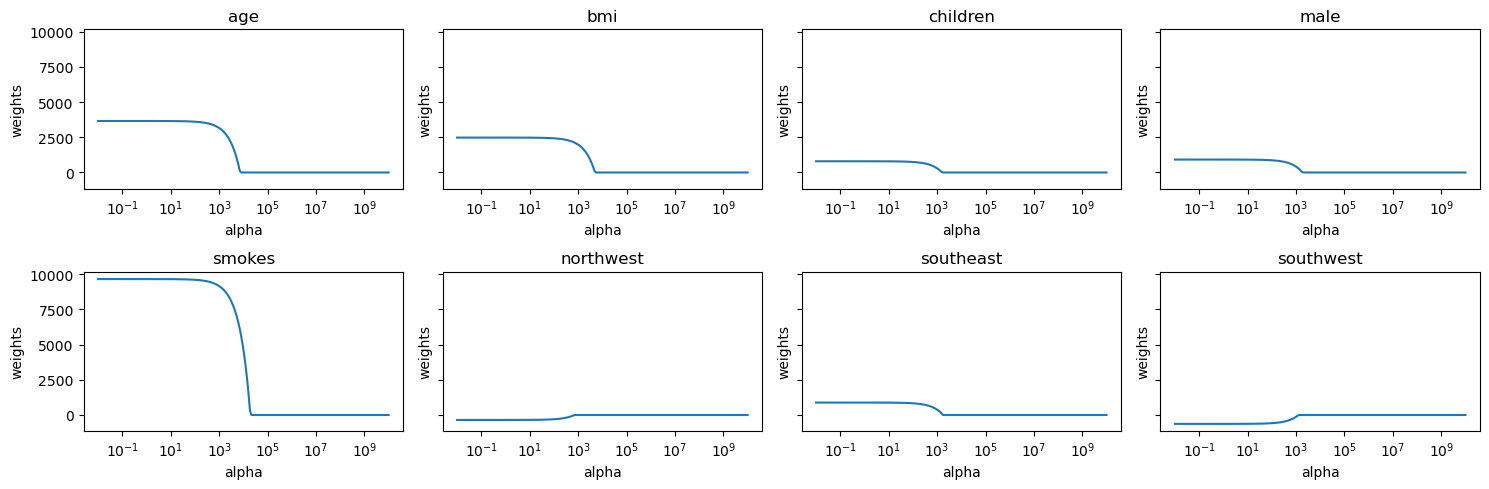

In [359]:
alphas = 10**np.linspace(10,-2,200)*0.5

columns = df.drop(['charges'], axis=1).columns
plot_cols = math.ceil(len(columns)/2.0)
fig, axes = plt.subplots(nrows=2, ncols=plot_cols, figsize=(15, 5), sharey=True)
i = 0
j = 0
for c in (columns):
    
    x_train, y_train, x_test, y_test, n_cols = split([c], 'charges')
    lasso = Lasso(max_iter = 10000)
    coefs = []
    
    for a in alphas:
        lasso.set_params(alpha=a)
        lasso.fit(x_train, y_train)
        coefs.append(lasso.coef_[0])
    
    ax = axes[i, j]
    ax.plot(alphas*2, coefs)
    ax.set_xscale('log')
    ax.set_yscale('linear')
    ax.set_title(c)
    ax.set_xlabel('alpha')
    ax.set_ylabel('weights')
    
    j += 1
    if j >= plot_cols:
        i += 1
        j = 0

plt.tight_layout()
plt.show()

Text(0, 0.5, 'weights')

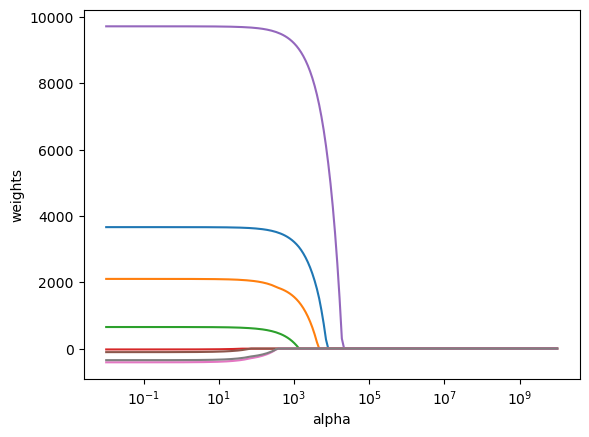

In [405]:
x_train, y_train, x_test, y_test, n_cols = split(df.drop(['charges'], axis=1).columns, target='charges')
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

### Random Forest Regressor

In [ ]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], scale=True, poly_degree=2)

reg = RandomForestRegressor() 

param_grid = [{'n_estimators': [10, 50, 100, 150, 175, 200], 'max_depth': [None, 2, 3, 4, 5, 6, 8, 10], 'random_state': [1234]}]

gscv = GridSearchCV(reg, param_grid, cv=KFold(n_splits=4, shuffle=False), scoring='neg_mean_squared_error')

gscv.fit(x_train, y_train)

print(f'best params: {gscv.best_params_}')

reg.set_params(**gscv.best_params_)

reg.fit(x_train, y_train)

rmse, r2, r2_adj = print_reg_stats(reg, x_train, y_train, x_test, y_test, already_trained=True)

result_RMSE['Random Forest - Grid Search CV'] = rmse
result_r2['Random Forest - Grid Search CV'] = r2
result_r2_adj['Random Forest - Grid Search CV'] = r2_adj

best params: {'max_depth': 4, 'n_estimators': 200, 'random_state': 1234}
TRAIN RMSE:         	 4411.902755131779
TRAIN R2 score:     	 0.8699118906424527
TRAIN Adj R2 score: 	 0.8686834854549403

TEST RMSE:          	 4089.9833533866167
TEST R2 score:      	 0.8753236557960953
TEST Adj R2 score:  	 0.8704724361772663


### Linear Regression

In [342]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], scale=True)

lin_reg = LinearRegression()

lin_reg.fit(x_train, y_train)

rmse, r2, r2_adj = print_reg_stats(lin_reg, x_train, y_train, x_test, y_test)

result_RMSE['Linear Reg.'] = rmse
result_r2['Linear Reg.'] = r2
result_r2_adj['Linear Reg.'] = r2_adj

TRAIN RMSE:         	 6122.0776837221
TRAIN R2 score:     	 0.7495140266647465
TRAIN Adj R2 score: 	 0.7488090942820019

TEST RMSE:          	 5930.542285251674
TEST R2 score:      	 0.7378621143876882
TEST Adj R2 score:  	 0.7348832747784574


### Linear Regression - 2^ degree polynomial

In [343]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], poly_degree=2)

lin_reg = LinearRegression()

lin_reg.fit(x_train, y_train)

rmse, r2, r2_adj = print_reg_stats(lin_reg, x_train, y_train, x_test, y_test)

result_RMSE['Linear Reg. - Poly 2'] = rmse
result_r2['Linear Reg. - Poly 2'] = r2
result_r2_adj['Linear Reg. - Poly 2'] = r2_adj

TRAIN RMSE:         	 4972.0883213273155
TRAIN R2 score:     	 0.834779699267884
TRAIN Adj R2 score: 	 0.8332195453421793

TEST RMSE:          	 4393.11222653875
TEST R2 score:      	 0.8561580459120834
TEST Adj R2 score:  	 0.850561082718001


###  Linear Regression - Grid Search CV

In [344]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], scale=True)

lin_reg = LinearRegression()

param_grid = {'fit_intercept': [True, False],
              'positive': [True, False],
              'copy_X': [True, False],
              'n_jobs': [None, -1, 1, 2, 4]}

grid_search = GridSearchCV(lin_reg, param_grid, cv=5)
grid_search.fit(x_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

print()

rmse, r2, r2_adj = print_reg_stats(grid_search, x_train, y_train, x_test, y_test)

result_RMSE['Linear Reg. - Grid Search CV'] = rmse
result_r2['Linear Reg. - Grid Search CV'] = r2
result_r2_adj['Linear Reg. - Grid Search CV'] = r2_adj

Best hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': True}
Best score: 0.744145550272439

TRAIN RMSE:         	 6122.0776837221
TRAIN R2 score:     	 0.7495140266647465
TRAIN Adj R2 score: 	 0.7488090942820019

TEST RMSE:          	 5930.5422852516685
TEST R2 score:      	 0.7378621143876887
TEST Adj R2 score:  	 0.7348832747784579


### Ridge

In [345]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], scale=True)

ridge = Ridge()

ridge.fit(x_train, y_train)

rmse, r2, r2_adj = print_reg_stats(ridge, x_train, y_train.reshape(-1), x_test, y_test.reshape(-1))

result_RMSE['Ridge'] = rmse
result_r2['Ridge'] = r2
result_r2_adj['Ridge'] = r2_adj

TRAIN RMSE:         	 6122.085675310184
TRAIN R2 score:     	 0.7495133727096255
TRAIN Adj R2 score: 	 0.7488084384864818

TEST RMSE:          	 5929.844132547711
TEST R2 score:      	 0.7379238293178259
TEST Adj R2 score:  	 0.7349456910146193


### Ridge - 2^ degree polynomial

In [346]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], poly_degree=2)

ridge = Ridge()

ridge.fit(x_train, y_train)

rmse, r2, r2_adj = print_reg_stats(ridge, x_train, y_train.reshape(-1), x_test, y_test.reshape(-1))

result_RMSE['Ridge - Poly 2'] = rmse
result_r2['Ridge - Poly 2'] = r2
result_r2_adj['Ridge - Poly 2'] = r2_adj

TRAIN RMSE:         	 4973.214015030046
TRAIN R2 score:     	 0.8347048781890546
TRAIN Adj R2 score: 	 0.833144017737582

TEST RMSE:          	 4408.995453183557
TEST R2 score:      	 0.8551160491036736
TEST Adj R2 score:  	 0.8494785412866959


### Ridge - GridSearchCV

In [ ]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], scale=True)

alphas = 10**np.linspace(10,-2,200)*0.5

parameters = {'alpha': alphas}

ridge_regressor = GridSearchCV(Ridge(), parameters,scoring='neg_mean_squared_error', cv=8)

ridge_regressor.fit(x_train, y_train)

ridge = Ridge(ridge_regressor.best_params_['alpha'])
ridge.fit(x_train, y_train)
rmse, r2, r2_adj = print_reg_stats(ridge, x_train, y_train, x_test, y_test)

result_RMSE['Ridge - Grid Search CV'] = rmse
result_r2['Ridge - Grid Search CV'] = r2
result_r2_adj['Ridge - Grid Search CV'] = r2_adj

TRAIN RMSE:         	 6122.147943561839
TRAIN R2 score:     	 0.7495082772423314
TRAIN Adj R2 score: 	 0.7488033286792235

TEST RMSE:          	 5928.518282479591
TEST R2 score:      	 0.7380410111038129
TEST Adj R2 score:  	 0.7350642044118108


### Ridge - RidgeCV

In [354]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], scale=True)

ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(x_train, y_train)
ridgecv.alpha_

ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(x_train, y_train)

rmse, r2, r2_adj = print_reg_stats(ridge, x_train, y_train, x_test, y_test)

result_RMSE['Ridge - RidgeCV'] = rmse
result_r2['Ridge - RidgeCV'] = r2
result_r2_adj['Ridge - RidgeCV'] = r2_adj

TRAIN RMSE:         	 6122.087776013216
TRAIN R2 score:     	 0.7495132008080431
TRAIN Adj R2 score: 	 0.7488082661011239

TEST RMSE:          	 5929.7588203504465
TEST R2 score:      	 0.7379313702017471
TEST Adj R2 score:  	 0.7349533175904034


### Lasso

In [355]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], scale=True)

lasso = Lasso()
lasso.fit(x_train, y_train)

rmse, r2, r2_adj = print_reg_stats(lasso, x_train, y_train, x_test, y_test)

result_RMSE['Lasso'] = rmse
result_r2['Lasso'] = r2
result_r2_adj['Lasso'] = r2_adj

TRAIN RMSE:         	 6122.077915280325
TRAIN R2 score:     	 0.7495140077162485
TRAIN Adj R2 score: 	 0.7488090752801779

TEST RMSE:          	 5930.418890926639
TEST R2 score:      	 0.7378730226619732
TEST Adj R2 score:  	 0.7348943070104047


### Lasso - 2^ degree polynomial

In [356]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], poly_degree=2)

lasso = Lasso(max_iter = 10000)
lasso.fit(x_train, y_train)

rmse, r2, r2_adj = print_reg_stats(lasso, x_train, y_train, x_test, y_test)

result_RMSE['Lasso - Poly 2'] = rmse
result_r2['Lasso - Poly 2'] = r2
result_r2_adj['Lasso - Poly 2'] = r2_adj

TRAIN RMSE:         	 4972.122087926477
TRAIN R2 score:     	 0.834777455161886
TRAIN Adj R2 score: 	 0.8332172800453788

TEST RMSE:          	 4394.744723641108
TEST R2 score:      	 0.8560511216217732
TEST Adj R2 score:  	 0.8504499979494686


### Lasso - GridSearchCV

In [357]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], scale=True)

alphas = 10**np.linspace(10,-2,200)*0.5

parameters = {'alpha': alphas}

lasso_regressor = GridSearchCV(Lasso(), parameters,scoring='neg_mean_squared_error', cv=8)

lasso_regressor.fit(x_train, y_train)

lasso = Lasso(lasso_regressor.best_params_['alpha'])
lasso.fit(x_train, y_train)
print(f'best alpha = {lasso_regressor.best_params_}')

rmse, r2, r2_adj = print_reg_stats(lasso, x_train, y_train, x_test, y_test)

result_RMSE['Lasso - Grid Search CV'] = rmse
result_r2['Lasso - Grid Search CV'] = r2
result_r2_adj['Lasso - Grid Search CV'] = r2_adj

best alpha = {'alpha': 9.020932046960377}
TRAIN RMSE:         	 6122.096575596824
TRAIN R2 score:     	 0.7495124807330632
TRAIN Adj R2 score: 	 0.7488075439996665

TEST RMSE:          	 5929.444711249831
TEST R2 score:      	 0.7379591338811262
TEST Adj R2 score:  	 0.7349813967661389


### Lasso - LassoCV

In [358]:
x_train, y_train, x_test, y_test, n_cols = split(['bmi', 'age', 'smokes'], ['charges'], scale=True)

lassocv = LassoCV(alphas = alphas)
lassocv.fit(x_train, y_train)

print(f'best alpha = {lassocv.alpha_}')

rmse, r2, r2_adj = print_reg_stats(lasso, x_train, y_train, x_test, y_test)

result_RMSE['Lasso - LassoCV'] = rmse
result_r2['Lasso - LassoCV'] = r2
result_r2_adj['Lasso - LassoCV'] = r2_adj

best alpha = 5.947670336851604
TRAIN RMSE:         	 6122.096575596824
TRAIN R2 score:     	 0.7495124807330632
TRAIN Adj R2 score: 	 0.7488075439996665

TEST RMSE:          	 5929.444711249831
TEST R2 score:      	 0.7379591338811262
TEST Adj R2 score:  	 0.7349813967661389


### Results

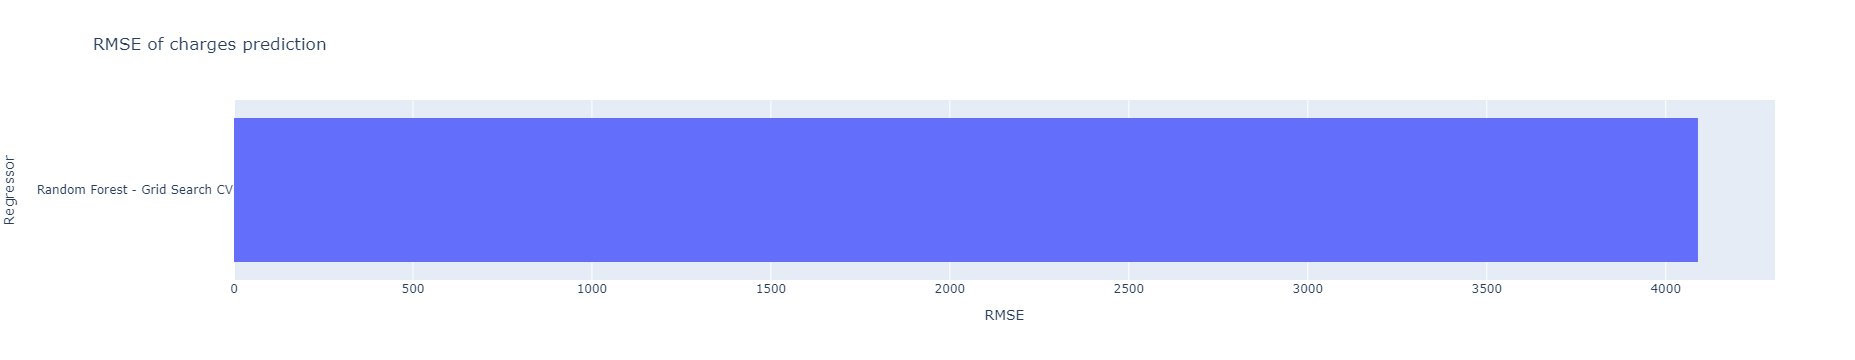

In [404]:
sorted_f1 = dict(sorted(result_RMSE.items(), key=lambda item: item[1]))

fig = px.histogram(y=list(sorted_f1.keys()), x=list(sorted_f1.values()), orientation='h', title='RMSE of charges prediction')

fig.layout['xaxis']['title'] = 'RMSE'
fig.layout['yaxis']['title'] = 'Regressor'

fig.update_xaxes()
fig.show()

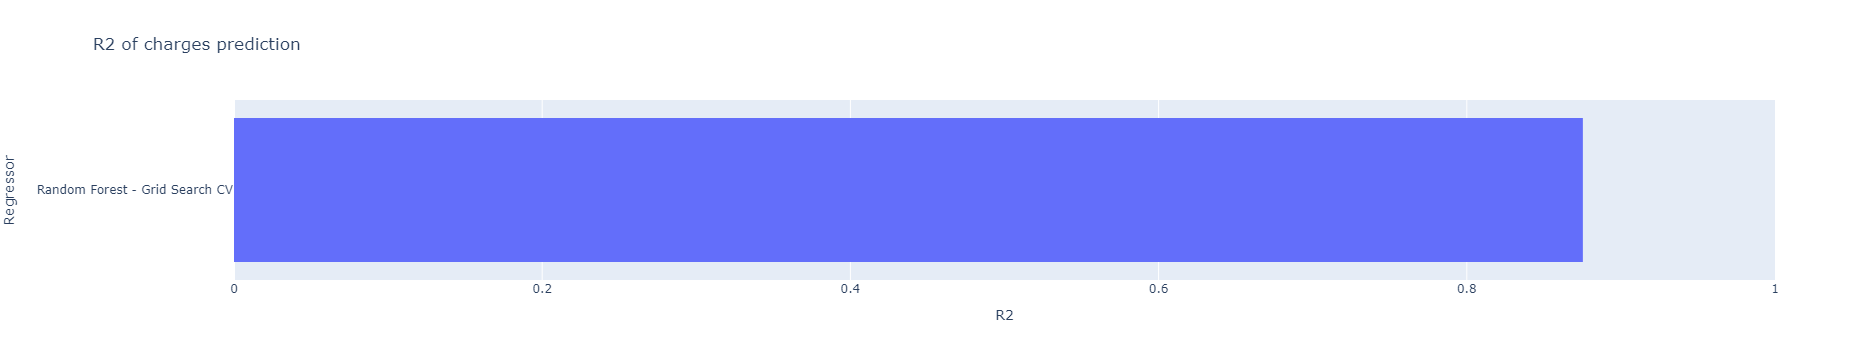

In [ ]:
sorted_f1 = dict(sorted(result_r2.items(), key=lambda item: item[1], reverse=True))

fig = px.histogram(y=list(sorted_f1.keys()), x=list(sorted_f1.values()), orientation='h', title='R2 of charges prediction')

fig.layout['xaxis']['title'] = 'R2'
fig.layout['yaxis']['title'] = 'Regressor'

fig.update_xaxes(range=(0,1))
fig.show()

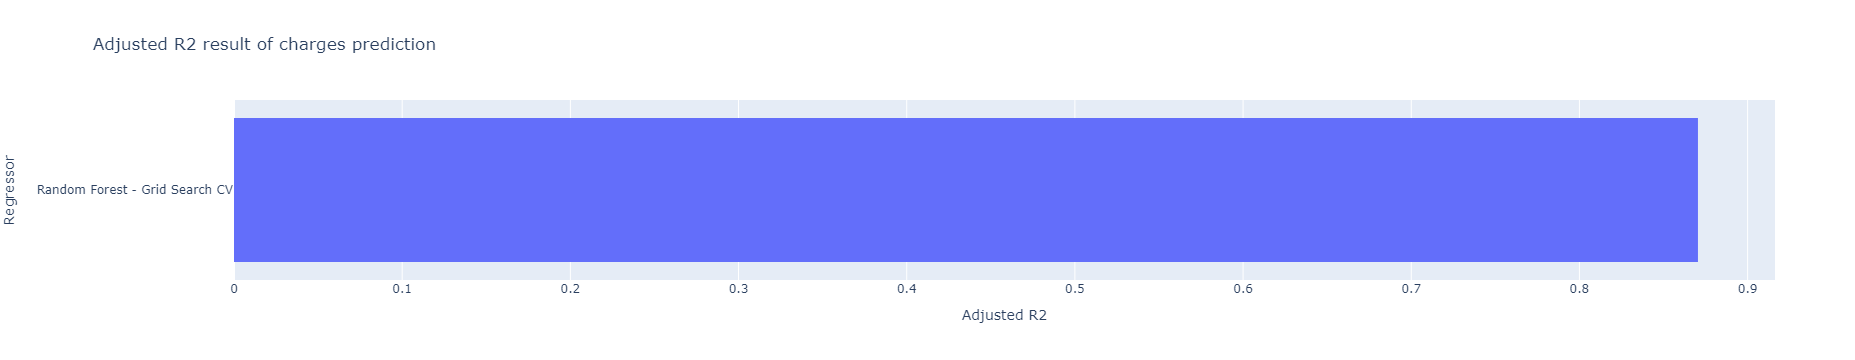

In [403]:
sorted_f1 = dict(sorted(result_r2_adj.items(), key=lambda item: item[1], reverse=True))

fig = px.histogram(y=list(sorted_f1.keys()), x=list(sorted_f1.values()), orientation='h', title='Adjusted R2 result of charges prediction')

fig.layout['xaxis']['title'] = 'Adjusted R2'
fig.layout['yaxis']['title'] = 'Regressor'

fig.update_xaxes()
fig.show()